## ADD DESCRIPTION FOR THE PROJECT ##

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

Loading data for the ML cup 2022

In [103]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [104]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

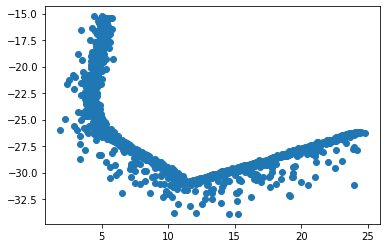

In [105]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [106]:

x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

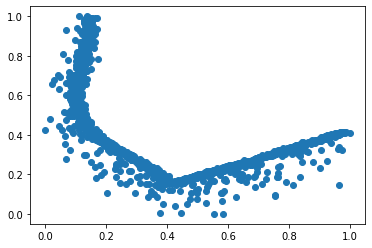

In [107]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])

Save the number of patterns id the training set (required to compute the mean Euclidian distance)

In [108]:
num_pattern_tr = len(x_mlcup_tr)

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [109]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [110]:
# This function computes the mean euclidean distance for Keras
def mean_euclidean_distance(y_true, y_pred, num_pattern=1):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) / num_pattern

n_fold_rs = 3

num_pattern_tot = num_pattern_tr / n_fold_rs

# This is the function that we have to pass to the function model.compile()
my_mean_euclidean_distance = lambda x, y : mean_euclidean_distance(x, y, num_pattern=num_pattern_tot)

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [111]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, ridge_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L2(ridge_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L2(ridge_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(ridge_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=2, max_units=11, min_ridge_lambda=0.0001, max_ridge_lambda=0.1, min_lr_rate=0.05, 
                max_lr_rate=0.6, min_mom=0.0, max_mom=0.9, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    ridge_lambda_sampling = "log"
    if(linear_reg):
        ridge_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units >= 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'ridge_lambda' represents the lambda coefficient for ridge regularization
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    ridge_lambda = hp.Float(
        "ridge_lambda", min_value=min_ridge_lambda, max_value=max_ridge_lambda, sampling=ridge_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, ridge_lambda=ridge_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [112]:
br_l = lambda a : build_regressor(a, my_metric=my_mean_euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, #50, # maximum number of attempts RIPRISTINA POI
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [113]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 11, 'step': 3, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [114]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 3 Complete [00h 01m 31s]
val_<lambda>: 0.00018683719827095047

Best val_<lambda> So Far: 0.00018683719827095047
Total elapsed time: 00h 02m 25s
INFO:tensorflow:Oracle triggered exit


In [115]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 11
ridge_lambda 0.004546636380428907
learning_rate 0.07297221935608139
momentum 0.37670073143768146

best hyperparameters n. 1
units 8
ridge_lambda 0.0002881944603196065
learning_rate 0.31407366157516625
momentum 0.02414301937647432

best hyperparameters n. 2
units 8
ridge_lambda 0.005900316111286504
learning_rate 0.10725519135494505
momentum 0.8235953634140901



Brief description of the final neural network's structure

In [116]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


In [117]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 11
ridge_lambda: 0.004546636380428907
learning_rate: 0.07297221935608139
momentum: 0.37670073143768146
Score: 0.00018683719827095047
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.0002881944603196065
learning_rate: 0.31407366157516625
momentum: 0.02414301937647432
Score: 0.00019806766310163462
Trial summary
Hyperparameters:
units: 8
ridge_lambda: 0.005900316111286504
learning_rate: 0.10725519135494505
momentum: 0.8235953634140901
Score: 0.00028704766009468585


Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [122]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
ridge_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance,
    min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=x, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3 # number of folds of the cross validation
)

Again, below there is a brief summary of the search space

In [123]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 11, 'max_value': 11, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0036373091043431253, 'conditions': [], 'min_value': 0.0036373091043431253, 'max_value': 0.0054559636565146875, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.05837777548486511, 'conditions': [], 'min_value': 0.05837777548486511, 'max_value': 0.08756666322729767, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.3013605851501452, 'conditions': [], 'min_value': 0.3013605851501452, 'max_value': 0.4520408777252178, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [124]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 2 Complete [00h 01m 14s]
val_<lambda>: 0.00018853047125351927

Best val_<lambda> So Far: 0.0001839018974957677
Total elapsed time: 00h 03m 02s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [125]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 11
ridge_lambda 0.003714630090812719
learning_rate 0.05895188367843896
momentum 0.3118650976949607

best hyperparameters n. 1
units 11
ridge_lambda 0.0038534383386297647
learning_rate 0.06974641814745655
momentum 0.42096477159778645



Brief description of the final neural network's structure

In [126]:
br_l2 = lambda a : build_regressor(a, my_metric=my_mean_euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 11)                110       
                                                                 
 dense_3 (Dense)             (None, 2)                 24        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [127]:
subset_size = int(0.3 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [128]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.0906 - <lambda>: 6.8386e-04 - val_loss: 0.0392 - val_<lambda>: 4.9680e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0330 - <lambda>: 4.3752e-04 - val_loss: 0.0299 - val_<lambda>: 4.2066e-04
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0265 - <lambda>: 3.7958e-04 - val_loss: 0.0250 - val_<lambda>: 3.7562e-04
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0228 - <lambda>: 3.4337e-04 - val_loss: 0.0223 - val_<lambda>: 3.4506e-04
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0205 - <lambda>: 3.1789e-04 - val_loss: 0.0198 - val_<lambda>: 3.2606e-04
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - <lambda>: 3.0168e-04 - val_loss: 0.0184 - val_<lambda>: 3.0951e-04
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0176 - <lambda>: 2.8882e

33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - <lambda>: 2.0258e-04 - val_loss: 0.0103 - val_<lambda>: 2.1443e-04
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - <lambda>: 2.0176e-04 - val_loss: 0.0102 - val_<lambda>: 2.1329e-04
Epoch 57/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - <lambda>: 2.0176e-04 - val_loss: 0.0101 - val_<lambda>: 2.1172e-04
Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - <lambda>: 2.0119e-04 - val_loss: 0.0101 - val_<lambda>: 2.1087e-04
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0099 - <lambda>: 2.0028e-04 - val_loss: 0.0100 - val_<lambda>: 2.0892e-04
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0099 - <lambda>: 1.9985e-04 - val_loss: 0.0101 - val_<lambda>: 2.0929e-04
Epoch 61/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 1.9935e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.8545e-04 - val_loss: 0.0090 - val_<lambda>: 1.9176e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.8514e-04 - val_loss: 0.0090 - val_<lambda>: 1.9119e-04
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.8529e-04 - val_loss: 0.0090 - val_<lambda>: 1.9241e-04
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.8494e-04 - val_loss: 0.0090 - val_<lambda>: 1.9138e-04
Epoch 113/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.8517e-04 - val_loss: 0.0090 - val_<lambda>: 1.9060e-04
Epoch 114/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - <lambda>: 1.8418e-04 - val_loss: 0.0090 - val_<lambda>: 1.9169e-04
Epoch 115/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - <lambda>: 1.8439e-

Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7828e-04 - val_loss: 0.0085 - val_<lambda>: 1.8402e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7860e-04 - val_loss: 0.0085 - val_<lambda>: 1.8359e-04
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7782e-04 - val_loss: 0.0085 - val_<lambda>: 1.8363e-04
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7812e-04 - val_loss: 0.0085 - val_<lambda>: 1.8460e-04
Epoch 167/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7815e-04 - val_loss: 0.0086 - val_<lambda>: 1.8444e-04
Epoch 168/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7839e-04 - val_loss: 0.0085 - val_<lambda>: 1.8271e-04
Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <la

Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7442e-04 - val_loss: 0.0083 - val_<lambda>: 1.8137e-04
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7341e-04 - val_loss: 0.0083 - val_<lambda>: 1.7902e-04
Epoch 219/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7416e-04 - val_loss: 0.0083 - val_<lambda>: 1.8014e-04
Epoch 220/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7351e-04 - val_loss: 0.0083 - val_<lambda>: 1.7939e-04
Epoch 221/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7352e-04 - val_loss: 0.0083 - val_<lambda>: 1.8176e-04
Epoch 222/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7368e-04 - val_loss: 0.0083 - val_<lambda>: 1.7896e-04
Epoch 223/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <la

Epoch 271/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7102e-04 - val_loss: 0.0081 - val_<lambda>: 1.7712e-04
Epoch 272/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7109e-04 - val_loss: 0.0082 - val_<lambda>: 1.7832e-04
Epoch 273/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7097e-04 - val_loss: 0.0081 - val_<lambda>: 1.7748e-04
Epoch 274/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7146e-04 - val_loss: 0.0081 - val_<lambda>: 1.7795e-04
Epoch 275/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7159e-04 - val_loss: 0.0081 - val_<lambda>: 1.7608e-04
Epoch 276/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7063e-04 - val_loss: 0.0081 - val_<lambda>: 1.7675e-04
Epoch 277/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - <lambda>: 2.3413e-04 - val_loss: 0.0142 - val_<lambda>: 2.4945e-04
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0133 - <lambda>: 2.3229e-04 - val_loss: 0.0140 - val_<lambda>: 2.4996e-04
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - <lambda>: 2.3024e-04 - val_loss: 0.0136 - val_<lambda>: 2.4372e-04
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129 - <lambda>: 2.2855e-04 - val_loss: 0.0134 - val_<lambda>: 2.4199e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - <lambda>: 2.2730e-04 - val_loss: 0.0132 - val_<lambda>: 2.4010e-04
Epoch 21/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.2506e-04 - val_loss: 0.0130 - val_<lambda>: 2.4045e-04
Epoch 22/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0124 - <lambda>: 2.2447e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.8943e-04 - val_loss: 0.0095 - val_<lambda>: 1.9780e-04
Epoch 71/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.8897e-04 - val_loss: 0.0095 - val_<lambda>: 1.9939e-04
Epoch 72/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.8891e-04 - val_loss: 0.0095 - val_<lambda>: 1.9996e-04
Epoch 73/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.8831e-04 - val_loss: 0.0094 - val_<lambda>: 1.9799e-04
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.8780e-04 - val_loss: 0.0095 - val_<lambda>: 2.0014e-04
Epoch 75/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.8795e-04 - val_loss: 0.0095 - val_<lambda>: 1.9823e-04
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.8798e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7863e-04 - val_loss: 0.0087 - val_<lambda>: 1.8854e-04
Epoch 125/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7821e-04 - val_loss: 0.0086 - val_<lambda>: 1.8784e-04
Epoch 126/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7835e-04 - val_loss: 0.0086 - val_<lambda>: 1.8759e-04
Epoch 127/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7789e-04 - val_loss: 0.0086 - val_<lambda>: 1.8688e-04
Epoch 128/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0084 - <lambda>: 1.7849e-04 - val_loss: 0.0086 - val_<lambda>: 1.8768e-04
Epoch 129/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7792e-04 - val_loss: 0.0087 - val_<lambda>: 1.8929e-04
Epoch 130/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7783e-

Epoch 178/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0079 - <lambda>: 1.7234e-04 - val_loss: 0.0083 - val_<lambda>: 1.8253e-04
Epoch 179/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7285e-04 - val_loss: 0.0083 - val_<lambda>: 1.8288e-04
Epoch 180/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7301e-04 - val_loss: 0.0083 - val_<lambda>: 1.8250e-04
Epoch 181/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7245e-04 - val_loss: 0.0083 - val_<lambda>: 1.8385e-04
Epoch 182/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7266e-04 - val_loss: 0.0082 - val_<lambda>: 1.8197e-04
Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7217e-04 - val_loss: 0.0083 - val_<lambda>: 1.8372e-04
Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <la

Epoch 232/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6872e-04 - val_loss: 0.0080 - val_<lambda>: 1.7738e-04
Epoch 233/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6848e-04 - val_loss: 0.0080 - val_<lambda>: 1.7785e-04
Epoch 234/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6826e-04 - val_loss: 0.0080 - val_<lambda>: 1.7730e-04
Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6824e-04 - val_loss: 0.0080 - val_<lambda>: 1.7827e-04
Epoch 236/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6869e-04 - val_loss: 0.0081 - val_<lambda>: 1.8126e-04
Epoch 237/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6900e-04 - val_loss: 0.0080 - val_<lambda>: 1.7819e-04
Epoch 238/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <la

Epoch 286/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6574e-04 - val_loss: 0.0078 - val_<lambda>: 1.7481e-04
Epoch 287/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6550e-04 - val_loss: 0.0078 - val_<lambda>: 1.7600e-04
Epoch 288/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6553e-04 - val_loss: 0.0078 - val_<lambda>: 1.7424e-04
Epoch 289/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6557e-04 - val_loss: 0.0078 - val_<lambda>: 1.7550e-04
Epoch 290/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6505e-04 - val_loss: 0.0079 - val_<lambda>: 1.7567e-04
Epoch 291/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6537e-04 - val_loss: 0.0078 - val_<lambda>: 1.7543e-04
Epoch 292/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <la

Epoch 340/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6340e-04 - val_loss: 0.0078 - val_<lambda>: 1.7594e-04
Epoch 341/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6396e-04 - val_loss: 0.0077 - val_<lambda>: 1.7345e-04
Epoch 342/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6338e-04 - val_loss: 0.0077 - val_<lambda>: 1.7350e-04
Epoch 343/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6360e-04 - val_loss: 0.0078 - val_<lambda>: 1.7679e-04
Epoch 344/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6326e-04 - val_loss: 0.0077 - val_<lambda>: 1.7290e-04
Epoch 345/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6365e-04 - val_loss: 0.0077 - val_<lambda>: 1.7367e-04
Epoch 346/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <la

Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0181 - <lambda>: 2.8443e-04 - val_loss: 0.0182 - val_<lambda>: 2.9215e-04
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0172 - <lambda>: 2.7631e-04 - val_loss: 0.0172 - val_<lambda>: 2.8134e-04
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - <lambda>: 2.6851e-04 - val_loss: 0.0167 - val_<lambda>: 2.7660e-04
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0158 - <lambda>: 2.6259e-04 - val_loss: 0.0158 - val_<lambda>: 2.6627e-04
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0152 - <lambda>: 2.5619e-04 - val_loss: 0.0153 - val_<lambda>: 2.6278e-04
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0147 - <lambda>: 2.5152e-04 - val_loss: 0.0150 - val_<lambda>: 2.5885e-04
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0144 - <lambda>: 2.4

33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.0490e-04 - val_loss: 0.0102 - val_<lambda>: 2.0692e-04
Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.0503e-04 - val_loss: 0.0101 - val_<lambda>: 2.0529e-04
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.0524e-04 - val_loss: 0.0102 - val_<lambda>: 2.0692e-04
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 2.0381e-04 - val_loss: 0.0101 - val_<lambda>: 2.0445e-04
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 2.0471e-04 - val_loss: 0.0100 - val_<lambda>: 2.0452e-04
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 2.0366e-04 - val_loss: 0.0100 - val_<lambda>: 2.0357e-04
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 2.0336e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.9235e-04 - val_loss: 0.0092 - val_<lambda>: 1.9516e-04
Epoch 116/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.9286e-04 - val_loss: 0.0092 - val_<lambda>: 1.9505e-04
Epoch 117/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.9263e-04 - val_loss: 0.0092 - val_<lambda>: 1.9334e-04
Epoch 118/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.9252e-04 - val_loss: 0.0092 - val_<lambda>: 1.9425e-04
Epoch 119/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.9245e-04 - val_loss: 0.0091 - val_<lambda>: 1.9253e-04
Epoch 120/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.9173e-04 - val_loss: 0.0092 - val_<lambda>: 1.9239e-04
Epoch 121/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.9216e-

Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8548e-04 - val_loss: 0.0087 - val_<lambda>: 1.8728e-04
Epoch 170/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8602e-04 - val_loss: 0.0087 - val_<lambda>: 1.8795e-04
Epoch 171/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8521e-04 - val_loss: 0.0087 - val_<lambda>: 1.8814e-04
Epoch 172/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8544e-04 - val_loss: 0.0087 - val_<lambda>: 1.8771e-04
Epoch 173/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8564e-04 - val_loss: 0.0087 - val_<lambda>: 1.8871e-04
Epoch 174/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8568e-04 - val_loss: 0.0088 - val_<lambda>: 1.8843e-04
Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <la

Epoch 223/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8106e-04 - val_loss: 0.0084 - val_<lambda>: 1.8533e-04
Epoch 224/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8111e-04 - val_loss: 0.0084 - val_<lambda>: 1.8481e-04
Epoch 225/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8068e-04 - val_loss: 0.0085 - val_<lambda>: 1.8613e-04
Epoch 226/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8045e-04 - val_loss: 0.0085 - val_<lambda>: 1.8676e-04
Epoch 227/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8168e-04 - val_loss: 0.0084 - val_<lambda>: 1.8260e-04
Epoch 228/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.8041e-04 - val_loss: 0.0084 - val_<lambda>: 1.8524e-04
Epoch 229/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <la

Epoch 277/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7775e-04 - val_loss: 0.0082 - val_<lambda>: 1.8299e-04
Epoch 278/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7720e-04 - val_loss: 0.0082 - val_<lambda>: 1.8277e-04
Epoch 279/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7646e-04 - val_loss: 0.0081 - val_<lambda>: 1.7957e-04
Epoch 280/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7599e-04 - val_loss: 0.0081 - val_<lambda>: 1.8086e-04
Epoch 281/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7688e-04 - val_loss: 0.0081 - val_<lambda>: 1.8210e-04
Epoch 282/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7663e-04 - val_loss: 0.0081 - val_<lambda>: 1.7969e-04
Epoch 283/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <la

Epoch 331/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7391e-04 - val_loss: 0.0080 - val_<lambda>: 1.8105e-04
Epoch 332/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7331e-04 - val_loss: 0.0079 - val_<lambda>: 1.7822e-04
Epoch 333/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7371e-04 - val_loss: 0.0079 - val_<lambda>: 1.7757e-04
Epoch 334/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7317e-04 - val_loss: 0.0079 - val_<lambda>: 1.7796e-04
Epoch 335/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7333e-04 - val_loss: 0.0081 - val_<lambda>: 1.8236e-04
Epoch 336/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7381e-04 - val_loss: 0.0079 - val_<lambda>: 1.7702e-04
Epoch 337/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <la

Epoch 385/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7124e-04 - val_loss: 0.0078 - val_<lambda>: 1.7601e-04
Epoch 386/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7168e-04 - val_loss: 0.0079 - val_<lambda>: 1.7847e-04
Epoch 387/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7174e-04 - val_loss: 0.0077 - val_<lambda>: 1.7575e-04
Epoch 388/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7152e-04 - val_loss: 0.0078 - val_<lambda>: 1.7696e-04
Epoch 389/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7134e-04 - val_loss: 0.0077 - val_<lambda>: 1.7492e-04
Epoch 390/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7163e-04 - val_loss: 0.0078 - val_<lambda>: 1.7830e-04
Epoch 391/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.0539e-04 - val_loss: 0.0103 - val_<lambda>: 2.0933e-04
Epoch 47/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.0490e-04 - val_loss: 0.0103 - val_<lambda>: 2.0906e-04
Epoch 48/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - <lambda>: 2.0399e-04 - val_loss: 0.0103 - val_<lambda>: 2.0834e-04
Epoch 49/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - <lambda>: 2.0405e-04 - val_loss: 0.0102 - val_<lambda>: 2.0680e-04
Epoch 50/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - <lambda>: 2.0311e-04 - val_loss: 0.0102 - val_<lambda>: 2.0709e-04
Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - <lambda>: 2.0278e-04 - val_loss: 0.0104 - val_<lambda>: 2.0948e-04
Epoch 52/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - <lambda>: 2.0241e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9005e-04 - val_loss: 0.0091 - val_<lambda>: 1.9257e-04
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.8962e-04 - val_loss: 0.0091 - val_<lambda>: 1.9226e-04
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.8925e-04 - val_loss: 0.0090 - val_<lambda>: 1.9190e-04
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.8946e-04 - val_loss: 0.0091 - val_<lambda>: 1.9279e-04
Epoch 104/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.8939e-04 - val_loss: 0.0090 - val_<lambda>: 1.9289e-04
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0092 - <lambda>: 1.8849e-04 - val_loss: 0.0091 - val_<lambda>: 1.9222e-04
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.8938e-

Epoch 154/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8281e-04 - val_loss: 0.0085 - val_<lambda>: 1.8559e-04
Epoch 155/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8227e-04 - val_loss: 0.0085 - val_<lambda>: 1.8666e-04
Epoch 156/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8227e-04 - val_loss: 0.0085 - val_<lambda>: 1.8643e-04
Epoch 157/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8218e-04 - val_loss: 0.0086 - val_<lambda>: 1.8791e-04
Epoch 158/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8195e-04 - val_loss: 0.0085 - val_<lambda>: 1.8625e-04
Epoch 159/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8245e-04 - val_loss: 0.0085 - val_<lambda>: 1.8478e-04
Epoch 160/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <la

Epoch 208/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7777e-04 - val_loss: 0.0082 - val_<lambda>: 1.8245e-04
Epoch 209/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7755e-04 - val_loss: 0.0082 - val_<lambda>: 1.8200e-04
Epoch 210/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7729e-04 - val_loss: 0.0082 - val_<lambda>: 1.8329e-04
Epoch 211/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7728e-04 - val_loss: 0.0082 - val_<lambda>: 1.8334e-04
Epoch 212/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7748e-04 - val_loss: 0.0082 - val_<lambda>: 1.8293e-04
Epoch 213/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7763e-04 - val_loss: 0.0082 - val_<lambda>: 1.8248e-04
Epoch 214/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <la

Epoch 262/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7401e-04 - val_loss: 0.0080 - val_<lambda>: 1.8009e-04
Epoch 263/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7352e-04 - val_loss: 0.0080 - val_<lambda>: 1.8040e-04
Epoch 264/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7343e-04 - val_loss: 0.0080 - val_<lambda>: 1.8143e-04
Epoch 265/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7352e-04 - val_loss: 0.0080 - val_<lambda>: 1.8041e-04
Epoch 266/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7404e-04 - val_loss: 0.0080 - val_<lambda>: 1.8136e-04
Epoch 1/1000
33/33 [==============================] - 1s 5ms/step - loss: 0.1020 - <lambda>: 7.9551e-04 - val_loss: 0.0640 - val_<lambda>: 6.5190e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0515 - <lambda

33/33 [==============================] - 0s 2ms/step - loss: 0.0131 - <lambda>: 2.3390e-04 - val_loss: 0.0128 - val_<lambda>: 2.3737e-04
Epoch 51/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - <lambda>: 2.3288e-04 - val_loss: 0.0127 - val_<lambda>: 2.3640e-04
Epoch 52/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - <lambda>: 2.3256e-04 - val_loss: 0.0127 - val_<lambda>: 2.3632e-04
Epoch 53/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129 - <lambda>: 2.3255e-04 - val_loss: 0.0126 - val_<lambda>: 2.3572e-04
Epoch 54/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0129 - <lambda>: 2.3234e-04 - val_loss: 0.0126 - val_<lambda>: 2.3698e-04
Epoch 55/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - <lambda>: 2.3179e-04 - val_loss: 0.0126 - val_<lambda>: 2.3579e-04
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0128 - <lambda>: 2.3117e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.1966e-04 - val_loss: 0.0110 - val_<lambda>: 2.2135e-04
Epoch 105/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.1991e-04 - val_loss: 0.0111 - val_<lambda>: 2.2281e-04
Epoch 106/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.1982e-04 - val_loss: 0.0110 - val_<lambda>: 2.2094e-04
Epoch 107/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.1863e-04 - val_loss: 0.0110 - val_<lambda>: 2.2090e-04
Epoch 108/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.1943e-04 - val_loss: 0.0112 - val_<lambda>: 2.2437e-04
Epoch 109/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.1923e-04 - val_loss: 0.0110 - val_<lambda>: 2.2037e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.1850e-

Epoch 158/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - <lambda>: 2.1448e-04 - val_loss: 0.0104 - val_<lambda>: 2.1781e-04
Epoch 159/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - <lambda>: 2.1489e-04 - val_loss: 0.0105 - val_<lambda>: 2.1736e-04
Epoch 160/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.1379e-04 - val_loss: 0.0104 - val_<lambda>: 2.1577e-04
Epoch 161/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.1418e-04 - val_loss: 0.0103 - val_<lambda>: 2.1566e-04
Epoch 162/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.1372e-04 - val_loss: 0.0103 - val_<lambda>: 2.1579e-04
Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.1361e-04 - val_loss: 0.0103 - val_<lambda>: 2.1559e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <la

Epoch 212/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1086e-04 - val_loss: 0.0099 - val_<lambda>: 2.1235e-04
Epoch 213/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1112e-04 - val_loss: 0.0099 - val_<lambda>: 2.1170e-04
Epoch 214/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1118e-04 - val_loss: 0.0099 - val_<lambda>: 2.1151e-04
Epoch 215/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 2.1026e-04 - val_loss: 0.0099 - val_<lambda>: 2.1146e-04
Epoch 216/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1046e-04 - val_loss: 0.0099 - val_<lambda>: 2.1177e-04
Epoch 217/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1143e-04 - val_loss: 0.0099 - val_<lambda>: 2.1127e-04
Epoch 218/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <la

Epoch 266/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0742e-04 - val_loss: 0.0097 - val_<lambda>: 2.0999e-04
Epoch 267/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0713e-04 - val_loss: 0.0096 - val_<lambda>: 2.0851e-04
Epoch 268/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0769e-04 - val_loss: 0.0097 - val_<lambda>: 2.1185e-04
Epoch 269/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0749e-04 - val_loss: 0.0096 - val_<lambda>: 2.0886e-04
Epoch 270/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0744e-04 - val_loss: 0.0098 - val_<lambda>: 2.1197e-04
Epoch 271/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.0722e-04 - val_loss: 0.0098 - val_<lambda>: 2.1200e-04
Epoch 272/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <la

Epoch 320/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.0292e-04 - val_loss: 0.0095 - val_<lambda>: 2.0785e-04
Epoch 321/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.0225e-04 - val_loss: 0.0093 - val_<lambda>: 2.0557e-04
Epoch 322/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.0338e-04 - val_loss: 0.0094 - val_<lambda>: 2.0671e-04
Epoch 323/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.0191e-04 - val_loss: 0.0093 - val_<lambda>: 2.0662e-04
Epoch 324/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.0223e-04 - val_loss: 0.0094 - val_<lambda>: 2.0733e-04
Epoch 325/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 2.0223e-04 - val_loss: 0.0093 - val_<lambda>: 2.0661e-04
Epoch 326/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <la

Epoch 374/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.9756e-04 - val_loss: 0.0090 - val_<lambda>: 2.0151e-04
Epoch 375/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.9631e-04 - val_loss: 0.0091 - val_<lambda>: 2.0355e-04
Epoch 376/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.9617e-04 - val_loss: 0.0090 - val_<lambda>: 2.0064e-04
Epoch 377/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.9649e-04 - val_loss: 0.0089 - val_<lambda>: 2.0012e-04
Epoch 378/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - <lambda>: 1.9569e-04 - val_loss: 0.0090 - val_<lambda>: 2.0153e-04
Epoch 379/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.9705e-04 - val_loss: 0.0089 - val_<lambda>: 2.0004e-04
Epoch 380/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <la

Epoch 428/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.9218e-04 - val_loss: 0.0089 - val_<lambda>: 2.0126e-04
Epoch 429/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9179e-04 - val_loss: 0.0086 - val_<lambda>: 1.9584e-04
Epoch 430/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9189e-04 - val_loss: 0.0086 - val_<lambda>: 1.9690e-04
Epoch 431/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9155e-04 - val_loss: 0.0087 - val_<lambda>: 1.9739e-04
Epoch 432/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9135e-04 - val_loss: 0.0086 - val_<lambda>: 1.9614e-04
Epoch 433/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9154e-04 - val_loss: 0.0091 - val_<lambda>: 2.0386e-04
Epoch 434/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <la

Epoch 482/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8669e-04 - val_loss: 0.0083 - val_<lambda>: 1.9232e-04
Epoch 483/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8683e-04 - val_loss: 0.0084 - val_<lambda>: 1.9265e-04
Epoch 484/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8695e-04 - val_loss: 0.0083 - val_<lambda>: 1.9154e-04
Epoch 485/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8696e-04 - val_loss: 0.0083 - val_<lambda>: 1.9170e-04
Epoch 486/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8630e-04 - val_loss: 0.0083 - val_<lambda>: 1.9249e-04
Epoch 487/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8624e-04 - val_loss: 0.0083 - val_<lambda>: 1.9085e-04
Epoch 488/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.3115e-04 - val_loss: 0.0125 - val_<lambda>: 2.3767e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0123 - <lambda>: 2.2983e-04 - val_loss: 0.0124 - val_<lambda>: 2.3723e-04
Epoch 21/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0122 - <lambda>: 2.2739e-04 - val_loss: 0.0122 - val_<lambda>: 2.3527e-04
Epoch 22/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0120 - <lambda>: 2.2622e-04 - val_loss: 0.0119 - val_<lambda>: 2.3105e-04
Epoch 23/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0119 - <lambda>: 2.2423e-04 - val_loss: 0.0118 - val_<lambda>: 2.2955e-04
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - <lambda>: 2.2274e-04 - val_loss: 0.0119 - val_<lambda>: 2.2944e-04
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2165e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9316e-04 - val_loss: 0.0098 - val_<lambda>: 2.0302e-04
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9308e-04 - val_loss: 0.0095 - val_<lambda>: 1.9853e-04
Epoch 75/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9272e-04 - val_loss: 0.0095 - val_<lambda>: 1.9893e-04
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9276e-04 - val_loss: 0.0095 - val_<lambda>: 1.9908e-04
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9245e-04 - val_loss: 0.0095 - val_<lambda>: 1.9733e-04
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9155e-04 - val_loss: 0.0095 - val_<lambda>: 1.9844e-04
Epoch 79/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9184e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8029e-04 - val_loss: 0.0087 - val_<lambda>: 1.8758e-04
Epoch 128/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7997e-04 - val_loss: 0.0088 - val_<lambda>: 1.8749e-04
Epoch 129/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7983e-04 - val_loss: 0.0087 - val_<lambda>: 1.8707e-04
Epoch 130/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7914e-04 - val_loss: 0.0087 - val_<lambda>: 1.8637e-04
Epoch 131/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7885e-04 - val_loss: 0.0089 - val_<lambda>: 1.8930e-04
Epoch 132/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7937e-04 - val_loss: 0.0087 - val_<lambda>: 1.8627e-04
Epoch 133/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7872e-

Epoch 181/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7240e-04 - val_loss: 0.0083 - val_<lambda>: 1.8005e-04
Epoch 182/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7245e-04 - val_loss: 0.0083 - val_<lambda>: 1.8033e-04
Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7273e-04 - val_loss: 0.0084 - val_<lambda>: 1.8108e-04
Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7328e-04 - val_loss: 0.0083 - val_<lambda>: 1.7960e-04
Epoch 185/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7238e-04 - val_loss: 0.0083 - val_<lambda>: 1.8000e-04
Epoch 186/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7205e-04 - val_loss: 0.0083 - val_<lambda>: 1.8196e-04
Epoch 187/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <la

Epoch 235/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.6843e-04 - val_loss: 0.0081 - val_<lambda>: 1.7987e-04
Epoch 236/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.6940e-04 - val_loss: 0.0080 - val_<lambda>: 1.7771e-04
Epoch 237/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.6895e-04 - val_loss: 0.0081 - val_<lambda>: 1.7971e-04
Epoch 238/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.6951e-04 - val_loss: 0.0081 - val_<lambda>: 1.7837e-04
Epoch 239/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.6914e-04 - val_loss: 0.0080 - val_<lambda>: 1.7854e-04
Epoch 240/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.6897e-04 - val_loss: 0.0080 - val_<lambda>: 1.7809e-04
Epoch 241/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <la

Epoch 289/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6727e-04 - val_loss: 0.0080 - val_<lambda>: 1.7724e-04
Epoch 290/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6713e-04 - val_loss: 0.0079 - val_<lambda>: 1.7689e-04
Epoch 291/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6701e-04 - val_loss: 0.0079 - val_<lambda>: 1.7632e-04
Epoch 292/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6731e-04 - val_loss: 0.0079 - val_<lambda>: 1.7654e-04
Epoch 293/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6701e-04 - val_loss: 0.0080 - val_<lambda>: 1.7766e-04
Epoch 294/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6722e-04 - val_loss: 0.0079 - val_<lambda>: 1.7625e-04
Epoch 295/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <la

Epoch 343/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6558e-04 - val_loss: 0.0078 - val_<lambda>: 1.7500e-04
Epoch 344/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6629e-04 - val_loss: 0.0078 - val_<lambda>: 1.7583e-04
Epoch 345/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6544e-04 - val_loss: 0.0078 - val_<lambda>: 1.7500e-04
Epoch 346/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6611e-04 - val_loss: 0.0078 - val_<lambda>: 1.7542e-04
Epoch 347/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6522e-04 - val_loss: 0.0078 - val_<lambda>: 1.7449e-04
Epoch 348/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6549e-04 - val_loss: 0.0079 - val_<lambda>: 1.7581e-04
Epoch 349/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <la

Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0213 - <lambda>: 2.9812e-04 - val_loss: 0.0218 - val_<lambda>: 3.1379e-04
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0200 - <lambda>: 2.8910e-04 - val_loss: 0.0205 - val_<lambda>: 3.0418e-04
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - <lambda>: 2.8007e-04 - val_loss: 0.0193 - val_<lambda>: 2.9409e-04
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0178 - <lambda>: 2.7172e-04 - val_loss: 0.0183 - val_<lambda>: 2.8590e-04
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0169 - <lambda>: 2.6406e-04 - val_loss: 0.0174 - val_<lambda>: 2.7791e-04
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0161 - <lambda>: 2.5705e-04 - val_loss: 0.0167 - val_<lambda>: 2.7258e-04
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0155 - <lambda>: 2.5

33/33 [==============================] - 0s 2ms/step - loss: 0.0101 - <lambda>: 1.9840e-04 - val_loss: 0.0103 - val_<lambda>: 2.0665e-04
Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0100 - <lambda>: 1.9730e-04 - val_loss: 0.0102 - val_<lambda>: 2.0517e-04
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0099 - <lambda>: 1.9666e-04 - val_loss: 0.0102 - val_<lambda>: 2.0498e-04
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0099 - <lambda>: 1.9596e-04 - val_loss: 0.0102 - val_<lambda>: 2.0552e-04
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0099 - <lambda>: 1.9615e-04 - val_loss: 0.0101 - val_<lambda>: 2.0341e-04
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 1.9546e-04 - val_loss: 0.0101 - val_<lambda>: 2.0351e-04
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 1.9464e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.7986e-04 - val_loss: 0.0090 - val_<lambda>: 1.8894e-04
Epoch 116/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.7980e-04 - val_loss: 0.0089 - val_<lambda>: 1.8929e-04
Epoch 117/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.7985e-04 - val_loss: 0.0089 - val_<lambda>: 1.8917e-04
Epoch 118/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.7921e-04 - val_loss: 0.0089 - val_<lambda>: 1.8917e-04
Epoch 119/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.7962e-04 - val_loss: 0.0089 - val_<lambda>: 1.8887e-04
Epoch 120/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7945e-04 - val_loss: 0.0089 - val_<lambda>: 1.8912e-04
Epoch 121/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7868e-

Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7230e-04 - val_loss: 0.0083 - val_<lambda>: 1.8186e-04
Epoch 170/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7167e-04 - val_loss: 0.0083 - val_<lambda>: 1.8212e-04
Epoch 171/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7176e-04 - val_loss: 0.0084 - val_<lambda>: 1.8273e-04
Epoch 172/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7225e-04 - val_loss: 0.0083 - val_<lambda>: 1.8238e-04
Epoch 173/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7148e-04 - val_loss: 0.0083 - val_<lambda>: 1.8177e-04
Epoch 174/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7110e-04 - val_loss: 0.0083 - val_<lambda>: 1.8156e-04
Epoch 175/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <la

Epoch 223/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6760e-04 - val_loss: 0.0080 - val_<lambda>: 1.7772e-04
Epoch 224/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6752e-04 - val_loss: 0.0080 - val_<lambda>: 1.7658e-04
Epoch 225/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6761e-04 - val_loss: 0.0080 - val_<lambda>: 1.7676e-04
Epoch 226/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6711e-04 - val_loss: 0.0080 - val_<lambda>: 1.7704e-04
Epoch 227/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6730e-04 - val_loss: 0.0080 - val_<lambda>: 1.7752e-04
Epoch 228/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6727e-04 - val_loss: 0.0080 - val_<lambda>: 1.7732e-04
Epoch 229/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <la

Epoch 277/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6428e-04 - val_loss: 0.0079 - val_<lambda>: 1.7898e-04
Epoch 278/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6500e-04 - val_loss: 0.0078 - val_<lambda>: 1.7501e-04
Epoch 279/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6458e-04 - val_loss: 0.0078 - val_<lambda>: 1.7565e-04
Epoch 280/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6380e-04 - val_loss: 0.0078 - val_<lambda>: 1.7577e-04
Epoch 281/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6452e-04 - val_loss: 0.0078 - val_<lambda>: 1.7424e-04
Epoch 282/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6475e-04 - val_loss: 0.0078 - val_<lambda>: 1.7451e-04
Epoch 283/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <la

Epoch 331/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6302e-04 - val_loss: 0.0077 - val_<lambda>: 1.7458e-04
Epoch 332/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6255e-04 - val_loss: 0.0077 - val_<lambda>: 1.7313e-04
Epoch 333/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6314e-04 - val_loss: 0.0077 - val_<lambda>: 1.7439e-04
Epoch 334/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6295e-04 - val_loss: 0.0077 - val_<lambda>: 1.7347e-04
Epoch 335/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6257e-04 - val_loss: 0.0077 - val_<lambda>: 1.7521e-04
Epoch 336/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6309e-04 - val_loss: 0.0077 - val_<lambda>: 1.7436e-04
Epoch 337/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0146 - <lambda>: 2.4089e-04 - val_loss: 0.0147 - val_<lambda>: 2.4854e-04
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0143 - <lambda>: 2.3867e-04 - val_loss: 0.0144 - val_<lambda>: 2.4605e-04
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0141 - <lambda>: 2.3711e-04 - val_loss: 0.0142 - val_<lambda>: 2.4343e-04
Epoch 26/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - <lambda>: 2.3397e-04 - val_loss: 0.0140 - val_<lambda>: 2.4299e-04
Epoch 27/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0137 - <lambda>: 2.3399e-04 - val_loss: 0.0137 - val_<lambda>: 2.4015e-04
Epoch 28/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - <lambda>: 2.3155e-04 - val_loss: 0.0137 - val_<lambda>: 2.4099e-04
Epoch 29/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0132 - <lambda>: 2.2985e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9241e-04 - val_loss: 0.0098 - val_<lambda>: 2.0235e-04
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9277e-04 - val_loss: 0.0096 - val_<lambda>: 1.9885e-04
Epoch 79/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9265e-04 - val_loss: 0.0095 - val_<lambda>: 1.9703e-04
Epoch 80/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9201e-04 - val_loss: 0.0095 - val_<lambda>: 1.9651e-04
Epoch 81/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9121e-04 - val_loss: 0.0095 - val_<lambda>: 1.9564e-04
Epoch 82/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9126e-04 - val_loss: 0.0095 - val_<lambda>: 1.9649e-04
Epoch 83/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9081e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8067e-04 - val_loss: 0.0087 - val_<lambda>: 1.8718e-04
Epoch 132/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8039e-04 - val_loss: 0.0087 - val_<lambda>: 1.8551e-04
Epoch 133/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8000e-04 - val_loss: 0.0087 - val_<lambda>: 1.8763e-04
Epoch 134/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8048e-04 - val_loss: 0.0086 - val_<lambda>: 1.8552e-04
Epoch 135/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7991e-04 - val_loss: 0.0086 - val_<lambda>: 1.8596e-04
Epoch 136/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8018e-04 - val_loss: 0.0086 - val_<lambda>: 1.8547e-04
Epoch 137/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.7967e-

Epoch 185/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0081 - <lambda>: 1.7534e-04 - val_loss: 0.0082 - val_<lambda>: 1.8123e-04
Epoch 186/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0081 - <lambda>: 1.7586e-04 - val_loss: 0.0082 - val_<lambda>: 1.7969e-04
Epoch 187/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7585e-04 - val_loss: 0.0082 - val_<lambda>: 1.8119e-04
Epoch 188/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0081 - <lambda>: 1.7486e-04 - val_loss: 0.0082 - val_<lambda>: 1.8173e-04
Epoch 189/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7539e-04 - val_loss: 0.0082 - val_<lambda>: 1.8115e-04
Epoch 190/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7486e-04 - val_loss: 0.0082 - val_<lambda>: 1.8078e-04
Epoch 191/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <la

Epoch 239/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7215e-04 - val_loss: 0.0080 - val_<lambda>: 1.7841e-04
Epoch 240/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7170e-04 - val_loss: 0.0080 - val_<lambda>: 1.7931e-04
Epoch 241/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7186e-04 - val_loss: 0.0081 - val_<lambda>: 1.7979e-04
Epoch 242/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7254e-04 - val_loss: 0.0080 - val_<lambda>: 1.7948e-04
Epoch 243/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7168e-04 - val_loss: 0.0080 - val_<lambda>: 1.7976e-04
Epoch 244/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7208e-04 - val_loss: 0.0080 - val_<lambda>: 1.7805e-04
Epoch 245/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.1626e-04 - val_loss: 0.0118 - val_<lambda>: 2.2726e-04
Epoch 34/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.1549e-04 - val_loss: 0.0117 - val_<lambda>: 2.2436e-04
Epoch 35/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0112 - <lambda>: 2.1483e-04 - val_loss: 0.0116 - val_<lambda>: 2.2511e-04
Epoch 36/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0112 - <lambda>: 2.1365e-04 - val_loss: 0.0115 - val_<lambda>: 2.2279e-04
Epoch 37/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0111 - <lambda>: 2.1271e-04 - val_loss: 0.0116 - val_<lambda>: 2.2391e-04
Epoch 38/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - <lambda>: 2.1237e-04 - val_loss: 0.0115 - val_<lambda>: 2.2264e-04
Epoch 39/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - <lambda>: 2.1177e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 1.9352e-04 - val_loss: 0.0096 - val_<lambda>: 2.0147e-04
Epoch 88/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9264e-04 - val_loss: 0.0097 - val_<lambda>: 2.0235e-04
Epoch 89/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9302e-04 - val_loss: 0.0095 - val_<lambda>: 2.0018e-04
Epoch 90/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9256e-04 - val_loss: 0.0095 - val_<lambda>: 1.9994e-04
Epoch 91/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9224e-04 - val_loss: 0.0095 - val_<lambda>: 1.9943e-04
Epoch 92/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 1.9248e-04 - val_loss: 0.0095 - val_<lambda>: 1.9985e-04
Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0093 - <lambda>: 1.9193e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0087 - <lambda>: 1.8279e-04 - val_loss: 0.0087 - val_<lambda>: 1.8821e-04
Epoch 142/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8278e-04 - val_loss: 0.0087 - val_<lambda>: 1.8932e-04
Epoch 143/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8225e-04 - val_loss: 0.0087 - val_<lambda>: 1.8848e-04
Epoch 144/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8216e-04 - val_loss: 0.0087 - val_<lambda>: 1.9005e-04
Epoch 145/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8256e-04 - val_loss: 0.0086 - val_<lambda>: 1.8701e-04
Epoch 146/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8214e-04 - val_loss: 0.0086 - val_<lambda>: 1.8742e-04
Epoch 147/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8212e-

Epoch 195/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7644e-04 - val_loss: 0.0082 - val_<lambda>: 1.8112e-04
Epoch 196/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0081 - <lambda>: 1.7554e-04 - val_loss: 0.0082 - val_<lambda>: 1.8233e-04
Epoch 197/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7584e-04 - val_loss: 0.0082 - val_<lambda>: 1.8180e-04
Epoch 198/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7518e-04 - val_loss: 0.0082 - val_<lambda>: 1.8212e-04
Epoch 199/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7592e-04 - val_loss: 0.0081 - val_<lambda>: 1.8017e-04
Epoch 200/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7528e-04 - val_loss: 0.0081 - val_<lambda>: 1.8053e-04
Epoch 201/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <la

Epoch 249/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7130e-04 - val_loss: 0.0080 - val_<lambda>: 1.7999e-04
Epoch 250/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7147e-04 - val_loss: 0.0079 - val_<lambda>: 1.7608e-04
Epoch 251/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7153e-04 - val_loss: 0.0079 - val_<lambda>: 1.7711e-04
Epoch 252/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7153e-04 - val_loss: 0.0079 - val_<lambda>: 1.7714e-04
Epoch 253/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7134e-04 - val_loss: 0.0079 - val_<lambda>: 1.7739e-04
Epoch 254/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7159e-04 - val_loss: 0.0079 - val_<lambda>: 1.7712e-04
Epoch 255/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <la

Epoch 303/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6933e-04 - val_loss: 0.0078 - val_<lambda>: 1.7599e-04
Epoch 304/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6919e-04 - val_loss: 0.0077 - val_<lambda>: 1.7547e-04
Epoch 305/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6913e-04 - val_loss: 0.0077 - val_<lambda>: 1.7504e-04
Epoch 306/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6876e-04 - val_loss: 0.0078 - val_<lambda>: 1.7772e-04
Epoch 307/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6891e-04 - val_loss: 0.0078 - val_<lambda>: 1.7498e-04
Epoch 308/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.6901e-04 - val_loss: 0.0077 - val_<lambda>: 1.7468e-04
Epoch 309/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <la

Epoch 357/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6791e-04 - val_loss: 0.0077 - val_<lambda>: 1.7456e-04
Epoch 358/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6821e-04 - val_loss: 0.0076 - val_<lambda>: 1.7361e-04
Epoch 359/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6763e-04 - val_loss: 0.0076 - val_<lambda>: 1.7546e-04
Epoch 360/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6830e-04 - val_loss: 0.0076 - val_<lambda>: 1.7430e-04
Epoch 361/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6811e-04 - val_loss: 0.0076 - val_<lambda>: 1.7545e-04
Epoch 362/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6819e-04 - val_loss: 0.0076 - val_<lambda>: 1.7498e-04
Epoch 363/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.0770e-04 - val_loss: 0.0107 - val_<lambda>: 2.0969e-04
Epoch 44/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - <lambda>: 2.0676e-04 - val_loss: 0.0108 - val_<lambda>: 2.1316e-04
Epoch 45/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - <lambda>: 2.0586e-04 - val_loss: 0.0106 - val_<lambda>: 2.1013e-04
Epoch 46/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.0484e-04 - val_loss: 0.0106 - val_<lambda>: 2.0971e-04
Epoch 47/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - <lambda>: 2.0450e-04 - val_loss: 0.0105 - val_<lambda>: 2.0767e-04
Epoch 48/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - <lambda>: 2.0418e-04 - val_loss: 0.0105 - val_<lambda>: 2.0797e-04
Epoch 49/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - <lambda>: 2.0358e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0091 - <lambda>: 1.8797e-04 - val_loss: 0.0091 - val_<lambda>: 1.9356e-04
Epoch 98/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.8768e-04 - val_loss: 0.0091 - val_<lambda>: 1.9228e-04
Epoch 99/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.8712e-04 - val_loss: 0.0091 - val_<lambda>: 1.9423e-04
Epoch 100/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.8769e-04 - val_loss: 0.0092 - val_<lambda>: 1.9550e-04
Epoch 101/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.8758e-04 - val_loss: 0.0091 - val_<lambda>: 1.9237e-04
Epoch 102/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.8670e-04 - val_loss: 0.0091 - val_<lambda>: 1.9365e-04
Epoch 103/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0090 - <lambda>: 1.8692e-04

33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8170e-04 - val_loss: 0.0087 - val_<lambda>: 1.8831e-04
Epoch 152/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8244e-04 - val_loss: 0.0087 - val_<lambda>: 1.9036e-04
Epoch 153/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.8241e-04 - val_loss: 0.0087 - val_<lambda>: 1.9072e-04
Epoch 154/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8218e-04 - val_loss: 0.0087 - val_<lambda>: 1.8807e-04
Epoch 155/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8172e-04 - val_loss: 0.0086 - val_<lambda>: 1.8910e-04
Epoch 156/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8162e-04 - val_loss: 0.0086 - val_<lambda>: 1.8817e-04
Epoch 157/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.8100e-

Epoch 205/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7856e-04 - val_loss: 0.0084 - val_<lambda>: 1.8631e-04
Epoch 206/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7869e-04 - val_loss: 0.0085 - val_<lambda>: 1.8791e-04
Epoch 207/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7864e-04 - val_loss: 0.0085 - val_<lambda>: 1.8660e-04
Epoch 208/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7850e-04 - val_loss: 0.0084 - val_<lambda>: 1.8723e-04
Epoch 209/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7863e-04 - val_loss: 0.0084 - val_<lambda>: 1.8634e-04
Epoch 210/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7867e-04 - val_loss: 0.0085 - val_<lambda>: 1.8788e-04
Epoch 211/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <la

Epoch 259/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7736e-04 - val_loss: 0.0083 - val_<lambda>: 1.8539e-04
Epoch 260/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7675e-04 - val_loss: 0.0083 - val_<lambda>: 1.8570e-04
Epoch 261/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7696e-04 - val_loss: 0.0083 - val_<lambda>: 1.8470e-04
Epoch 262/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7662e-04 - val_loss: 0.0083 - val_<lambda>: 1.8529e-04
Epoch 263/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7601e-04 - val_loss: 0.0083 - val_<lambda>: 1.8573e-04
Epoch 264/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.7638e-04 - val_loss: 0.0083 - val_<lambda>: 1.8530e-04
Epoch 265/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <la

Epoch 313/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7481e-04 - val_loss: 0.0082 - val_<lambda>: 1.8397e-04
Epoch 314/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7562e-04 - val_loss: 0.0082 - val_<lambda>: 1.8236e-04
Epoch 315/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.7503e-04 - val_loss: 0.0082 - val_<lambda>: 1.8323e-04
Epoch 316/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7536e-04 - val_loss: 0.0082 - val_<lambda>: 1.8251e-04
Epoch 317/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7507e-04 - val_loss: 0.0082 - val_<lambda>: 1.8448e-04
Epoch 318/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.7465e-04 - val_loss: 0.0082 - val_<lambda>: 1.8521e-04
Epoch 319/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <la

Epoch 367/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7339e-04 - val_loss: 0.0080 - val_<lambda>: 1.8143e-04
Epoch 368/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7340e-04 - val_loss: 0.0080 - val_<lambda>: 1.8069e-04
Epoch 369/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7317e-04 - val_loss: 0.0081 - val_<lambda>: 1.8230e-04
Epoch 370/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7318e-04 - val_loss: 0.0081 - val_<lambda>: 1.8157e-04
Epoch 371/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7312e-04 - val_loss: 0.0082 - val_<lambda>: 1.8330e-04
Epoch 372/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <lambda>: 1.7326e-04 - val_loss: 0.0082 - val_<lambda>: 1.8482e-04
Epoch 373/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0078 - <la

Epoch 421/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7151e-04 - val_loss: 0.0079 - val_<lambda>: 1.7964e-04
Epoch 422/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7183e-04 - val_loss: 0.0080 - val_<lambda>: 1.8153e-04
Epoch 423/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7209e-04 - val_loss: 0.0079 - val_<lambda>: 1.8009e-04
Epoch 424/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7154e-04 - val_loss: 0.0079 - val_<lambda>: 1.8055e-04
Epoch 425/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7174e-04 - val_loss: 0.0080 - val_<lambda>: 1.7921e-04
Epoch 426/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7148e-04 - val_loss: 0.0079 - val_<lambda>: 1.7865e-04
Epoch 427/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <la

Epoch 475/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6961e-04 - val_loss: 0.0078 - val_<lambda>: 1.7888e-04
Epoch 476/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7008e-04 - val_loss: 0.0078 - val_<lambda>: 1.7798e-04
Epoch 477/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6911e-04 - val_loss: 0.0078 - val_<lambda>: 1.8017e-04
Epoch 478/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6993e-04 - val_loss: 0.0079 - val_<lambda>: 1.7969e-04
Epoch 479/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.6987e-04 - val_loss: 0.0080 - val_<lambda>: 1.8061e-04
Epoch 480/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7025e-04 - val_loss: 0.0078 - val_<lambda>: 1.7786e-04
Epoch 481/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <la

Epoch 529/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6836e-04 - val_loss: 0.0079 - val_<lambda>: 1.8045e-04
Epoch 530/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6799e-04 - val_loss: 0.0077 - val_<lambda>: 1.7882e-04
Epoch 531/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6859e-04 - val_loss: 0.0078 - val_<lambda>: 1.7643e-04
Epoch 532/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6761e-04 - val_loss: 0.0078 - val_<lambda>: 1.7792e-04
Epoch 533/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - <lambda>: 1.6855e-04 - val_loss: 0.0077 - val_<lambda>: 1.7637e-04
Epoch 534/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0075 - <lambda>: 1.6837e-04 - val_loss: 0.0077 - val_<lambda>: 1.7741e-04
Epoch 535/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0075 - <la

Epoch 583/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6710e-04 - val_loss: 0.0077 - val_<lambda>: 1.7774e-04
Epoch 584/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6673e-04 - val_loss: 0.0076 - val_<lambda>: 1.7464e-04
Epoch 585/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6700e-04 - val_loss: 0.0076 - val_<lambda>: 1.7447e-04
Epoch 586/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6609e-04 - val_loss: 0.0077 - val_<lambda>: 1.7884e-04
Epoch 587/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6714e-04 - val_loss: 0.0076 - val_<lambda>: 1.7597e-04
Epoch 588/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0074 - <lambda>: 1.6720e-04 - val_loss: 0.0076 - val_<lambda>: 1.7558e-04


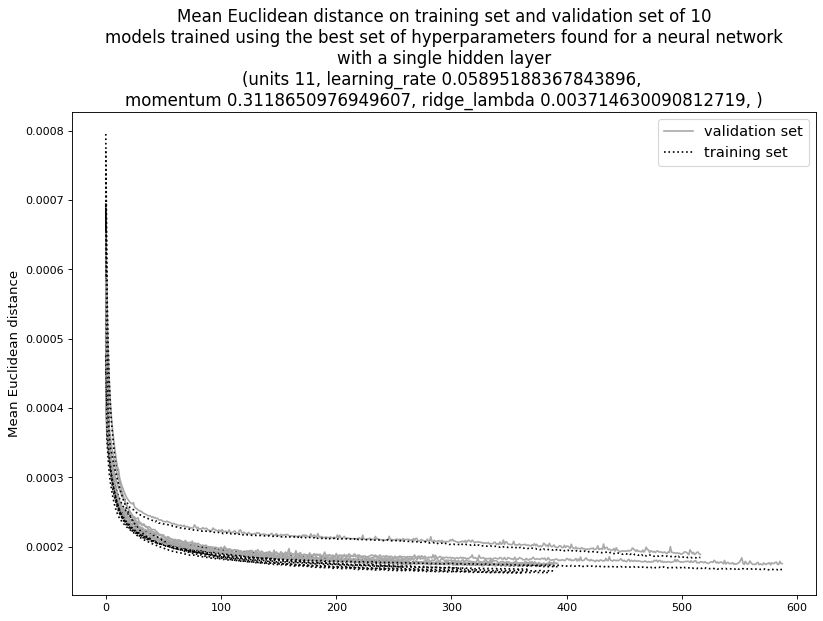

In [129]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_<lambda>']
    list_values_tr[i] = hist[i].history['<lambda>']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png")
plt.show()

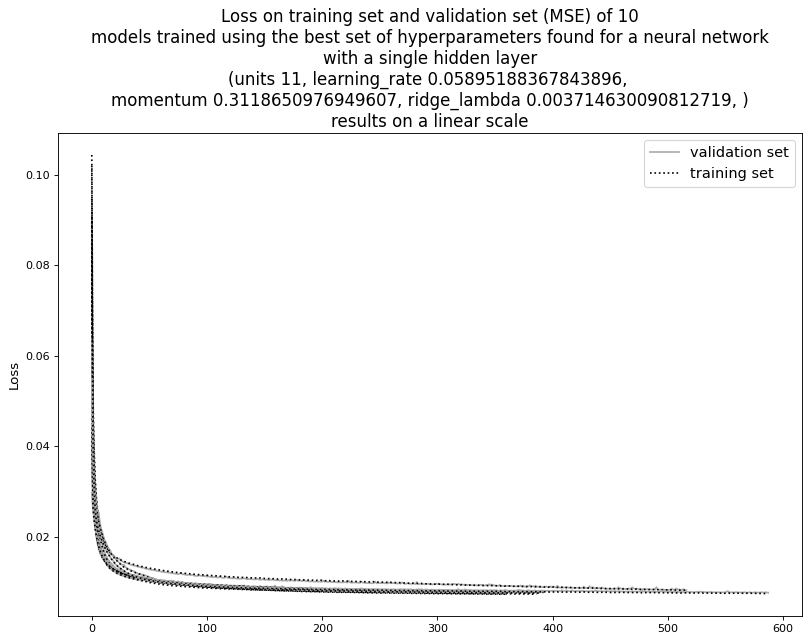

In [130]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

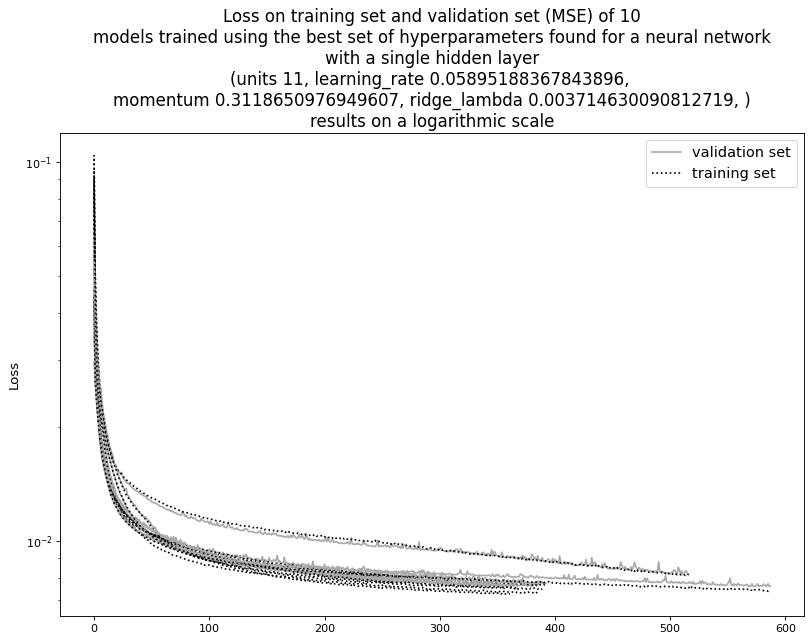

In [131]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [132]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 2
num_units_max = 5
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [133]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': None, 'sampling': 'linear'}


In [134]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 2 Complete [00h 01m 35s]
val_<lambda>: 0.00017381986799591687

Best val_<lambda> So Far: 0.00017381986799591687
Total elapsed time: 00h 02m 19s
INFO:tensorflow:Oracle triggered exit


In [135]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 4
ridge_lambda 0.002457564048567833
learning_rate 0.0686227465225218
momentum 0.6910539135846734

best hyperparameters n. 1
units 4
ridge_lambda 0.035869504344532954
learning_rate 0.1257593725967842
momentum 0.6126290231098146



Brief description of the final neural network's structure

In [137]:
br_l = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 40        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


In [138]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.002457564048567833
learning_rate: 0.0686227465225218
momentum: 0.6910539135846734
Score: 0.00017381986799591687
Trial summary
Hyperparameters:
units: 4
ridge_lambda: 0.035869504344532954
learning_rate: 0.1257593725967842
momentum: 0.6126290231098146
Score: 0.0002970372552226763


Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [142]:
h_param = ["units", "ridge_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
ridge_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

ridge_lambda_min = (ridge_lambda / 10) * 8
ridge_lambda_max = (ridge_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, 
    min_units=num_units, max_units=num_units, min_ridge_lambda=ridge_lambda_min,
    max_ridge_lambda=ridge_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=x, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_<lambda>", direction="min"), # value to minimize
    max_trials=30, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3
)

Again, below there is a brief summary of the search space

In [143]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 4, 'step': 1, 'sampling': None}
ridge_lambda (Float)
{'default': 0.0019660512388542666, 'conditions': [], 'min_value': 0.0019660512388542666, 'max_value': 0.0029490768582814, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.05489819721801744, 'conditions': [], 'min_value': 0.05489819721801744, 'max_value': 0.08234729582702616, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.5528431308677387, 'conditions': [], 'min_value': 0.5528431308677387, 'max_value': 0.8292646963016082, 'step': None, 'sampling': 'linear'}


In [144]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 2 Complete [00h 00m 58s]
val_<lambda>: 0.0002963264608600487

Best val_<lambda> So Far: 0.0002963264608600487
Total elapsed time: 00h 01m 49s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [145]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "ridge_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 4
ridge_lambda 0.0021749995203406793
learning_rate 0.06655459843623682
momentum 0.615630225668848

best hyperparameters n. 1
units 4
ridge_lambda 0.002528180766711445
learning_rate 0.06527059352010045
momentum 0.5595317706732275



Brief description of the final neural network's structure

In [146]:
br_l2 = lambda a: build_regressor(
    a, my_metric=my_mean_euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 40        
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [147]:
subset_size = int(0.3 * len(x_mlcup_tr))

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [148]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.0551 - <lambda>: 5.4594e-04 - val_loss: 0.0373 - val_<lambda>: 4.5757e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0315 - <lambda>: 4.1360e-04 - val_loss: 0.0289 - val_<lambda>: 4.0011e-04
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0262 - <lambda>: 3.7091e-04 - val_loss: 0.0247 - val_<lambda>: 3.6370e-04
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0226 - <lambda>: 3.3906e-04 - val_loss: 0.0214 - val_<lambda>: 3.3604e-04
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0199 - <lambda>: 3.1273e-04 - val_loss: 0.0194 - val_<lambda>: 3.1267e-04
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0182 - <lambda>: 2.9498e-04 - val_loss: 0.0178 - val_<lambda>: 2.9436e-04
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0170 - <lambda>: 2.8246e

33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0862e-04 - val_loss: 0.0099 - val_<lambda>: 2.1159e-04
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0098 - <lambda>: 2.0778e-04 - val_loss: 0.0099 - val_<lambda>: 2.1128e-04
Epoch 57/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.0742e-04 - val_loss: 0.0097 - val_<lambda>: 2.0871e-04
Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.0706e-04 - val_loss: 0.0098 - val_<lambda>: 2.1005e-04
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.0628e-04 - val_loss: 0.0097 - val_<lambda>: 2.0819e-04
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0528e-04 - val_loss: 0.0095 - val_<lambda>: 2.0586e-04
Epoch 61/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0458e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.8690e-04 - val_loss: 0.0080 - val_<lambda>: 1.8711e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8703e-04 - val_loss: 0.0082 - val_<lambda>: 1.8912e-04
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.8359e-04 - val_loss: 0.0080 - val_<lambda>: 1.8687e-04
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.8453e-04 - val_loss: 0.0080 - val_<lambda>: 1.8580e-04
Epoch 113/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.8514e-04 - val_loss: 0.0080 - val_<lambda>: 1.8563e-04
Epoch 114/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.8392e-04 - val_loss: 0.0079 - val_<lambda>: 1.8603e-04
Epoch 115/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0081 - <lambda>: 1.8398e-

Epoch 163/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.6978e-04 - val_loss: 0.0071 - val_<lambda>: 1.7253e-04
Epoch 164/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.6902e-04 - val_loss: 0.0072 - val_<lambda>: 1.7418e-04
Epoch 165/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.6932e-04 - val_loss: 0.0072 - val_<lambda>: 1.7372e-04
Epoch 166/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0073 - <lambda>: 1.7040e-04 - val_loss: 0.0072 - val_<lambda>: 1.7450e-04
Epoch 167/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.6842e-04 - val_loss: 0.0072 - val_<lambda>: 1.7302e-04
Epoch 168/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <lambda>: 1.7023e-04 - val_loss: 0.0071 - val_<lambda>: 1.7163e-04
Epoch 169/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - <la

33/33 [==============================] - 0s 2ms/step - loss: 0.0142 - <lambda>: 2.4885e-04 - val_loss: 0.0138 - val_<lambda>: 2.5222e-04
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0139 - <lambda>: 2.4767e-04 - val_loss: 0.0135 - val_<lambda>: 2.4765e-04
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0138 - <lambda>: 2.4670e-04 - val_loss: 0.0132 - val_<lambda>: 2.4589e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0135 - <lambda>: 2.4343e-04 - val_loss: 0.0132 - val_<lambda>: 2.4876e-04
Epoch 21/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0134 - <lambda>: 2.4271e-04 - val_loss: 0.0130 - val_<lambda>: 2.4550e-04
Epoch 22/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0132 - <lambda>: 2.4135e-04 - val_loss: 0.0128 - val_<lambda>: 2.4401e-04
Epoch 23/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0130 - <lambda>: 2.3995e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0699e-04 - val_loss: 0.0096 - val_<lambda>: 2.1220e-04
Epoch 72/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0732e-04 - val_loss: 0.0095 - val_<lambda>: 2.1128e-04
Epoch 73/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0689e-04 - val_loss: 0.0096 - val_<lambda>: 2.1424e-04
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0611e-04 - val_loss: 0.0096 - val_<lambda>: 2.1426e-04
Epoch 75/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0577e-04 - val_loss: 0.0097 - val_<lambda>: 2.1705e-04
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0635e-04 - val_loss: 0.0093 - val_<lambda>: 2.1082e-04
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0646e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.8408e-04 - val_loss: 0.0082 - val_<lambda>: 1.9305e-04
Epoch 126/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.8276e-04 - val_loss: 0.0081 - val_<lambda>: 1.9062e-04
Epoch 127/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8238e-04 - val_loss: 0.0082 - val_<lambda>: 1.9238e-04
Epoch 128/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.8284e-04 - val_loss: 0.0081 - val_<lambda>: 1.8902e-04
Epoch 129/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8150e-04 - val_loss: 0.0081 - val_<lambda>: 1.8850e-04
Epoch 130/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8087e-04 - val_loss: 0.0079 - val_<lambda>: 1.8723e-04
Epoch 131/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8155e-

33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - <lambda>: 3.4477e-04 - val_loss: 0.0220 - val_<lambda>: 3.6166e-04
Epoch 22/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - <lambda>: 3.4493e-04 - val_loss: 0.0219 - val_<lambda>: 3.6078e-04
Epoch 23/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - <lambda>: 3.4387e-04 - val_loss: 0.0218 - val_<lambda>: 3.6160e-04
Epoch 24/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0207 - <lambda>: 3.4419e-04 - val_loss: 0.0218 - val_<lambda>: 3.5949e-04
Epoch 25/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0206 - <lambda>: 3.4262e-04 - val_loss: 0.0217 - val_<lambda>: 3.6053e-04
Epoch 26/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0206 - <lambda>: 3.4359e-04 - val_loss: 0.0219 - val_<lambda>: 3.6082e-04
Epoch 27/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0205 - <lambda>: 3.4228e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0194 - <lambda>: 3.3750e-04 - val_loss: 0.0203 - val_<lambda>: 3.5097e-04
Epoch 76/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - <lambda>: 3.3603e-04 - val_loss: 0.0202 - val_<lambda>: 3.5154e-04
Epoch 77/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - <lambda>: 3.3802e-04 - val_loss: 0.0204 - val_<lambda>: 3.5063e-04
Epoch 78/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - <lambda>: 3.3678e-04 - val_loss: 0.0205 - val_<lambda>: 3.5222e-04
Epoch 79/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - <lambda>: 3.3627e-04 - val_loss: 0.0204 - val_<lambda>: 3.5043e-04
Epoch 80/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - <lambda>: 3.3648e-04 - val_loss: 0.0201 - val_<lambda>: 3.4913e-04
Epoch 81/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0193 - <lambda>: 3.3692e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0176 - <lambda>: 3.1712e-04 - val_loss: 0.0187 - val_<lambda>: 3.2996e-04
Epoch 130/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0175 - <lambda>: 3.1558e-04 - val_loss: 0.0180 - val_<lambda>: 3.2561e-04
Epoch 131/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0171 - <lambda>: 3.1089e-04 - val_loss: 0.0177 - val_<lambda>: 3.2284e-04
Epoch 132/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0168 - <lambda>: 3.0771e-04 - val_loss: 0.0178 - val_<lambda>: 3.1921e-04
Epoch 133/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0164 - <lambda>: 3.0167e-04 - val_loss: 0.0174 - val_<lambda>: 3.1995e-04
Epoch 134/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - <lambda>: 2.9930e-04 - val_loss: 0.0168 - val_<lambda>: 3.1136e-04
Epoch 135/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0159 - <lambda>: 2.9436e-

Epoch 183/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0680e-04 - val_loss: 0.0099 - val_<lambda>: 2.1893e-04
Epoch 184/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0786e-04 - val_loss: 0.0102 - val_<lambda>: 2.2197e-04
Epoch 185/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0739e-04 - val_loss: 0.0098 - val_<lambda>: 2.1563e-04
Epoch 186/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0097 - <lambda>: 2.0963e-04 - val_loss: 0.0101 - val_<lambda>: 2.2176e-04
Epoch 187/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.0881e-04 - val_loss: 0.0098 - val_<lambda>: 2.1544e-04
Epoch 188/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.0605e-04 - val_loss: 0.0097 - val_<lambda>: 2.1375e-04
Epoch 189/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <la

Epoch 237/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9439e-04 - val_loss: 0.0087 - val_<lambda>: 2.0032e-04
Epoch 238/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0088 - <lambda>: 1.9654e-04 - val_loss: 0.0087 - val_<lambda>: 2.0048e-04
Epoch 239/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9320e-04 - val_loss: 0.0092 - val_<lambda>: 2.0828e-04
Epoch 240/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <lambda>: 1.9322e-04 - val_loss: 0.0086 - val_<lambda>: 1.9910e-04
Epoch 241/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - <lambda>: 1.9317e-04 - val_loss: 0.0088 - val_<lambda>: 2.0318e-04
Epoch 242/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.0086 - <lambda>: 1.9272e-04 - val_loss: 0.0086 - val_<lambda>: 1.9961e-04
Epoch 243/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0086 - <la

Epoch 291/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8280e-04 - val_loss: 0.0079 - val_<lambda>: 1.8685e-04
Epoch 292/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8312e-04 - val_loss: 0.0081 - val_<lambda>: 1.9370e-04
Epoch 293/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.8413e-04 - val_loss: 0.0080 - val_<lambda>: 1.8868e-04
Epoch 294/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8388e-04 - val_loss: 0.0079 - val_<lambda>: 1.8635e-04
Epoch 295/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <lambda>: 1.8476e-04 - val_loss: 0.0079 - val_<lambda>: 1.8959e-04
Epoch 296/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0080 - <lambda>: 1.8464e-04 - val_loss: 0.0079 - val_<lambda>: 1.8646e-04
Epoch 297/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0079 - <la

Epoch 345/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.8156e-04 - val_loss: 0.0077 - val_<lambda>: 1.8560e-04
Epoch 1/1000
33/33 [==============================] - 1s 6ms/step - loss: 0.0824 - <lambda>: 7.4046e-04 - val_loss: 0.0671 - val_<lambda>: 6.9238e-04
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0523 - <lambda>: 5.9975e-04 - val_loss: 0.0378 - val_<lambda>: 4.9793e-04
Epoch 3/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0297 - <lambda>: 4.2685e-04 - val_loss: 0.0259 - val_<lambda>: 3.9431e-04
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0238 - <lambda>: 3.6982e-04 - val_loss: 0.0234 - val_<lambda>: 3.6899e-04
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0224 - <lambda>: 3.5908e-04 - val_loss: 0.0223 - val_<lambda>: 3.6234e-04
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - <lambda>: 3.528

33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.3411e-04 - val_loss: 0.0128 - val_<lambda>: 2.4137e-04
Epoch 55/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.3465e-04 - val_loss: 0.0127 - val_<lambda>: 2.3847e-04
Epoch 56/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0126 - <lambda>: 2.3460e-04 - val_loss: 0.0129 - val_<lambda>: 2.3835e-04
Epoch 57/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0124 - <lambda>: 2.3318e-04 - val_loss: 0.0128 - val_<lambda>: 2.3971e-04
Epoch 58/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0124 - <lambda>: 2.3370e-04 - val_loss: 0.0130 - val_<lambda>: 2.3930e-04
Epoch 59/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.3293e-04 - val_loss: 0.0127 - val_<lambda>: 2.3917e-04
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0123 - <lambda>: 2.3142e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.2352e-04 - val_loss: 0.0129 - val_<lambda>: 2.4424e-04
Epoch 109/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2486e-04 - val_loss: 0.0116 - val_<lambda>: 2.3103e-04
Epoch 110/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2356e-04 - val_loss: 0.0120 - val_<lambda>: 2.3582e-04
Epoch 111/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2565e-04 - val_loss: 0.0118 - val_<lambda>: 2.3034e-04
Epoch 112/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0113 - <lambda>: 2.2263e-04 - val_loss: 0.0116 - val_<lambda>: 2.2970e-04
Epoch 113/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2575e-04 - val_loss: 0.0117 - val_<lambda>: 2.3100e-04
Epoch 114/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2353e-

33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.0453e-04 - val_loss: 0.0108 - val_<lambda>: 2.1147e-04
Epoch 39/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.0374e-04 - val_loss: 0.0109 - val_<lambda>: 2.1148e-04
Epoch 40/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - <lambda>: 2.0296e-04 - val_loss: 0.0107 - val_<lambda>: 2.1220e-04
Epoch 41/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - <lambda>: 2.0293e-04 - val_loss: 0.0106 - val_<lambda>: 2.0881e-04
Epoch 42/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0105 - <lambda>: 2.0202e-04 - val_loss: 0.0105 - val_<lambda>: 2.0976e-04
Epoch 43/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - <lambda>: 2.0066e-04 - val_loss: 0.0104 - val_<lambda>: 2.0823e-04
Epoch 44/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0103 - <lambda>: 2.0024e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7969e-04 - val_loss: 0.0084 - val_<lambda>: 1.8471e-04
Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.8050e-04 - val_loss: 0.0085 - val_<lambda>: 1.8619e-04
Epoch 94/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0083 - <lambda>: 1.7943e-04 - val_loss: 0.0084 - val_<lambda>: 1.8406e-04
Epoch 95/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7911e-04 - val_loss: 0.0085 - val_<lambda>: 1.8625e-04
Epoch 96/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7980e-04 - val_loss: 0.0083 - val_<lambda>: 1.8489e-04
Epoch 97/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7852e-04 - val_loss: 0.0082 - val_<lambda>: 1.8330e-04
Epoch 98/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0082 - <lambda>: 1.7846e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7411e-04 - val_loss: 0.0078 - val_<lambda>: 1.7911e-04
Epoch 147/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7517e-04 - val_loss: 0.0081 - val_<lambda>: 1.8558e-04
Epoch 148/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7488e-04 - val_loss: 0.0080 - val_<lambda>: 1.8259e-04
Epoch 149/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7365e-04 - val_loss: 0.0082 - val_<lambda>: 1.8582e-04
Epoch 150/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - <lambda>: 1.7506e-04 - val_loss: 0.0078 - val_<lambda>: 1.7988e-04
Epoch 151/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7442e-04 - val_loss: 0.0078 - val_<lambda>: 1.7922e-04
Epoch 152/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0076 - <lambda>: 1.7461e-

33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - <lambda>: 3.1886e-04 - val_loss: 0.0199 - val_<lambda>: 3.3087e-04
Epoch 36/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0188 - <lambda>: 3.1564e-04 - val_loss: 0.0197 - val_<lambda>: 3.2804e-04
Epoch 37/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0186 - <lambda>: 3.1263e-04 - val_loss: 0.0197 - val_<lambda>: 3.2933e-04
Epoch 38/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0184 - <lambda>: 3.1064e-04 - val_loss: 0.0193 - val_<lambda>: 3.2589e-04
Epoch 39/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0182 - <lambda>: 3.0749e-04 - val_loss: 0.0190 - val_<lambda>: 3.2356e-04
Epoch 40/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0180 - <lambda>: 3.0691e-04 - val_loss: 0.0188 - val_<lambda>: 3.2035e-04
Epoch 41/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0177 - <lambda>: 3.0268e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - <lambda>: 2.3477e-04 - val_loss: 0.0134 - val_<lambda>: 2.5178e-04
Epoch 90/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0127 - <lambda>: 2.3604e-04 - val_loss: 0.0136 - val_<lambda>: 2.5184e-04
Epoch 91/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0126 - <lambda>: 2.3394e-04 - val_loss: 0.0133 - val_<lambda>: 2.4978e-04
Epoch 92/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0126 - <lambda>: 2.3416e-04 - val_loss: 0.0132 - val_<lambda>: 2.4986e-04
Epoch 93/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.3330e-04 - val_loss: 0.0133 - val_<lambda>: 2.5155e-04
Epoch 94/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0125 - <lambda>: 2.3263e-04 - val_loss: 0.0133 - val_<lambda>: 2.5054e-04
Epoch 95/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0124 - <lambda>: 2.3205e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - <lambda>: 2.2917e-04 - val_loss: 0.0126 - val_<lambda>: 2.4404e-04
Epoch 144/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2763e-04 - val_loss: 0.0121 - val_<lambda>: 2.3964e-04
Epoch 145/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - <lambda>: 2.2899e-04 - val_loss: 0.0123 - val_<lambda>: 2.4050e-04
Epoch 146/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - <lambda>: 2.2770e-04 - val_loss: 0.0121 - val_<lambda>: 2.3985e-04
Epoch 147/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2694e-04 - val_loss: 0.0121 - val_<lambda>: 2.3818e-04
Epoch 148/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2657e-04 - val_loss: 0.0121 - val_<lambda>: 2.3821e-04
Epoch 149/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2738e-

33/33 [==============================] - 0s 2ms/step - loss: 0.0220 - <lambda>: 3.5840e-04 - val_loss: 0.0226 - val_<lambda>: 3.6501e-04
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0220 - <lambda>: 3.5841e-04 - val_loss: 0.0225 - val_<lambda>: 3.6392e-04
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0219 - <lambda>: 3.5763e-04 - val_loss: 0.0223 - val_<lambda>: 3.6343e-04
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - <lambda>: 3.5707e-04 - val_loss: 0.0223 - val_<lambda>: 3.6325e-04
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0216 - <lambda>: 3.5568e-04 - val_loss: 0.0221 - val_<lambda>: 3.6231e-04
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0216 - <lambda>: 3.5536e-04 - val_loss: 0.0221 - val_<lambda>: 3.6099e-04
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - <lambda>: 3.5463e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0198 - <lambda>: 3.4163e-04 - val_loss: 0.0203 - val_<lambda>: 3.5011e-04
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0198 - <lambda>: 3.4231e-04 - val_loss: 0.0203 - val_<lambda>: 3.4884e-04
Epoch 68/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0198 - <lambda>: 3.4181e-04 - val_loss: 0.0202 - val_<lambda>: 3.5010e-04
Epoch 69/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - <lambda>: 3.4106e-04 - val_loss: 0.0202 - val_<lambda>: 3.4968e-04
Epoch 70/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - <lambda>: 3.4266e-04 - val_loss: 0.0206 - val_<lambda>: 3.5018e-04
Epoch 71/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0198 - <lambda>: 3.4218e-04 - val_loss: 0.0204 - val_<lambda>: 3.5024e-04
Epoch 72/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0197 - <lambda>: 3.4085e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0202 - <lambda>: 3.0690e-04 - val_loss: 0.0203 - val_<lambda>: 3.1812e-04
Epoch 6/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0191 - <lambda>: 2.9719e-04 - val_loss: 0.0191 - val_<lambda>: 3.0298e-04
Epoch 7/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0182 - <lambda>: 2.8816e-04 - val_loss: 0.0189 - val_<lambda>: 3.0958e-04
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0174 - <lambda>: 2.8259e-04 - val_loss: 0.0176 - val_<lambda>: 2.9271e-04
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0169 - <lambda>: 2.7829e-04 - val_loss: 0.0168 - val_<lambda>: 2.8312e-04
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0162 - <lambda>: 2.7251e-04 - val_loss: 0.0165 - val_<lambda>: 2.8510e-04
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0159 - <lambda>: 2.7215e-04 - val_l

33/33 [==============================] - 0s 2ms/step - loss: 0.0103 - <lambda>: 2.1802e-04 - val_loss: 0.0102 - val_<lambda>: 2.1820e-04
Epoch 60/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0104 - <lambda>: 2.1865e-04 - val_loss: 0.0101 - val_<lambda>: 2.1782e-04
Epoch 61/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1727e-04 - val_loss: 0.0099 - val_<lambda>: 2.1479e-04
Epoch 62/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1715e-04 - val_loss: 0.0100 - val_<lambda>: 2.1742e-04
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1645e-04 - val_loss: 0.0099 - val_<lambda>: 2.1560e-04
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1765e-04 - val_loss: 0.0100 - val_<lambda>: 2.1723e-04
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0102 - <lambda>: 2.1684e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.1262e-04 - val_loss: 0.0094 - val_<lambda>: 2.1671e-04
Epoch 114/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.1195e-04 - val_loss: 0.0091 - val_<lambda>: 2.1026e-04
Epoch 115/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.1298e-04 - val_loss: 0.0094 - val_<lambda>: 2.1463e-04
Epoch 116/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.1200e-04 - val_loss: 0.0091 - val_<lambda>: 2.1137e-04
Epoch 117/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.1167e-04 - val_loss: 0.0092 - val_<lambda>: 2.1253e-04
Epoch 118/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.1261e-04 - val_loss: 0.0095 - val_<lambda>: 2.1739e-04
Epoch 119/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.1284e-

33/33 [==============================] - 0s 2ms/step - loss: 0.0235 - <lambda>: 3.6592e-04 - val_loss: 0.0240 - val_<lambda>: 3.7387e-04
Epoch 15/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0232 - <lambda>: 3.6530e-04 - val_loss: 0.0238 - val_<lambda>: 3.7143e-04
Epoch 16/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0229 - <lambda>: 3.6299e-04 - val_loss: 0.0239 - val_<lambda>: 3.7277e-04
Epoch 17/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0228 - <lambda>: 3.6189e-04 - val_loss: 0.0230 - val_<lambda>: 3.6689e-04
Epoch 18/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0223 - <lambda>: 3.5829e-04 - val_loss: 0.0230 - val_<lambda>: 3.6453e-04
Epoch 19/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0220 - <lambda>: 3.5566e-04 - val_loss: 0.0224 - val_<lambda>: 3.6377e-04
Epoch 20/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - <lambda>: 3.5350e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0117 - <lambda>: 2.3001e-04 - val_loss: 0.0117 - val_<lambda>: 2.3457e-04
Epoch 69/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2758e-04 - val_loss: 0.0118 - val_<lambda>: 2.3449e-04
Epoch 70/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2890e-04 - val_loss: 0.0116 - val_<lambda>: 2.3126e-04
Epoch 71/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0116 - <lambda>: 2.2769e-04 - val_loss: 0.0116 - val_<lambda>: 2.3212e-04
Epoch 72/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2550e-04 - val_loss: 0.0127 - val_<lambda>: 2.4596e-04
Epoch 73/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0115 - <lambda>: 2.2542e-04 - val_loss: 0.0123 - val_<lambda>: 2.4101e-04
Epoch 74/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0114 - <lambda>: 2.2561e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0263 - <lambda>: 3.6528e-04 - val_loss: 0.0269 - val_<lambda>: 3.7603e-04
Epoch 9/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0249 - <lambda>: 3.5623e-04 - val_loss: 0.0260 - val_<lambda>: 3.7389e-04
Epoch 10/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0239 - <lambda>: 3.5023e-04 - val_loss: 0.0243 - val_<lambda>: 3.5940e-04
Epoch 11/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0227 - <lambda>: 3.4047e-04 - val_loss: 0.0232 - val_<lambda>: 3.5197e-04
Epoch 12/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0217 - <lambda>: 3.3175e-04 - val_loss: 0.0221 - val_<lambda>: 3.4494e-04
Epoch 13/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0208 - <lambda>: 3.2474e-04 - val_loss: 0.0214 - val_<lambda>: 3.3411e-04
Epoch 14/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0200 - <lambda>: 3.1548e-04 - va

33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - <lambda>: 2.2469e-04 - val_loss: 0.0115 - val_<lambda>: 2.3569e-04
Epoch 63/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0110 - <lambda>: 2.2579e-04 - val_loss: 0.0109 - val_<lambda>: 2.2811e-04
Epoch 64/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0109 - <lambda>: 2.2501e-04 - val_loss: 0.0109 - val_<lambda>: 2.2756e-04
Epoch 65/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.2369e-04 - val_loss: 0.0111 - val_<lambda>: 2.3110e-04
Epoch 66/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.2376e-04 - val_loss: 0.0109 - val_<lambda>: 2.2866e-04
Epoch 67/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0108 - <lambda>: 2.2365e-04 - val_loss: 0.0112 - val_<lambda>: 2.3406e-04
Epoch 68/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - <lambda>: 2.2355e-04 - v

33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.0983e-04 - val_loss: 0.0094 - val_<lambda>: 2.1369e-04
Epoch 117/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.1027e-04 - val_loss: 0.0093 - val_<lambda>: 2.1198e-04
Epoch 118/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0096 - <lambda>: 2.1168e-04 - val_loss: 0.0093 - val_<lambda>: 2.1177e-04
Epoch 119/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.0911e-04 - val_loss: 0.0095 - val_<lambda>: 2.1478e-04
Epoch 120/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0095 - <lambda>: 2.0988e-04 - val_loss: 0.0094 - val_<lambda>: 2.1441e-04
Epoch 121/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.0877e-04 - val_loss: 0.0093 - val_<lambda>: 2.1232e-04
Epoch 122/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - <lambda>: 2.1012e-

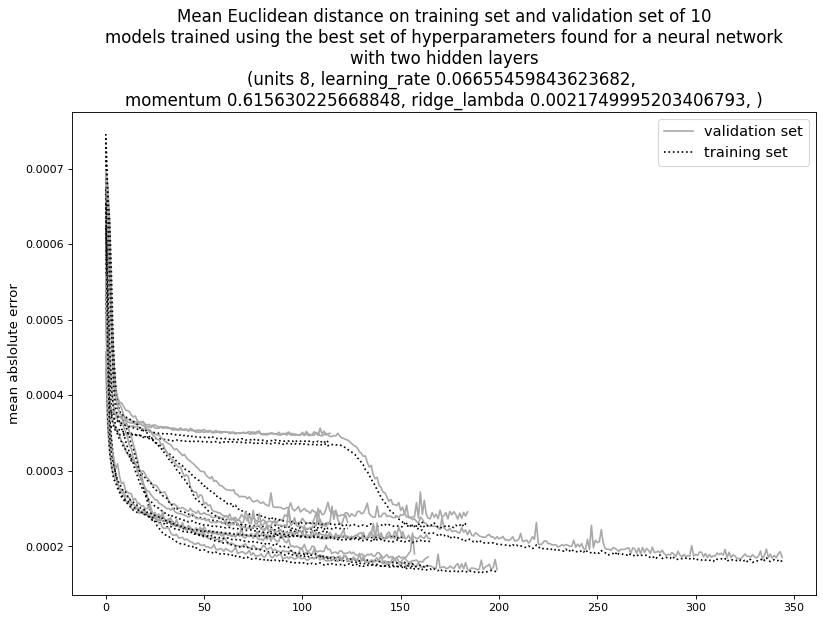

In [149]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "ridge_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_<lambda>']
    list_values_tr[i] = hist2[i].history['<lambda>']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png")
plt.show()

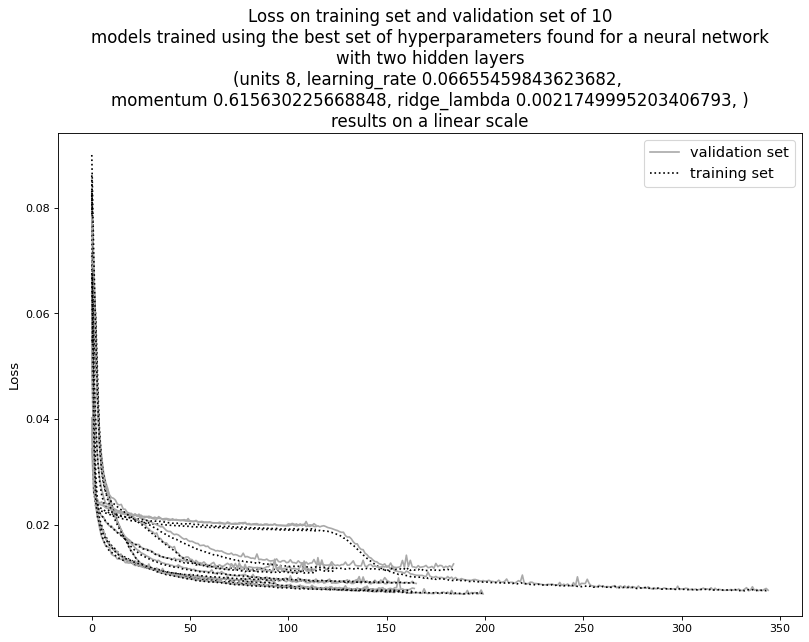

In [150]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

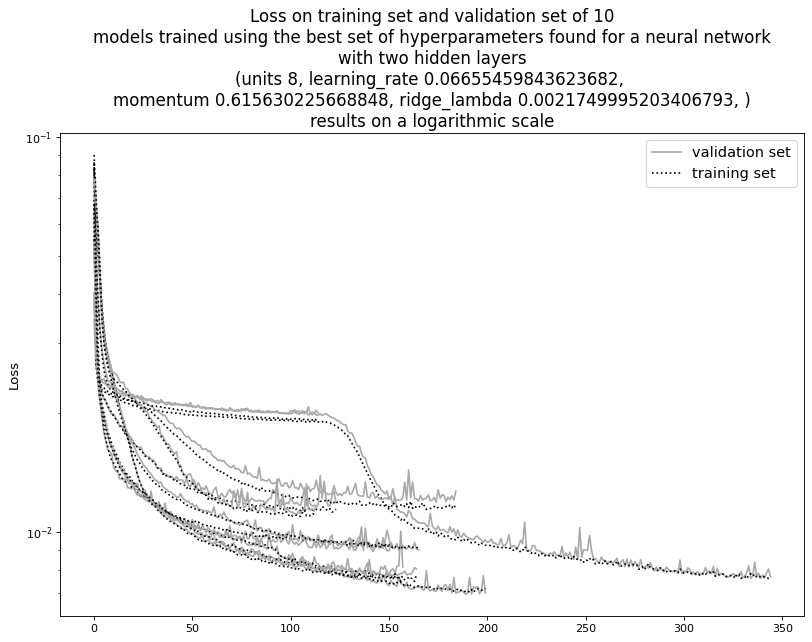

In [151]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

The neural networks with only one hidden layer have better results with respect to the others with two hidden layers. Therefore we decided to return a model among the ones obtained using a single hidden layer.  To retrieve a final model among the ones obtained using a random search, we chose the average model (among those having a single hidden layer) in terms of mean absolute error
on the validation set

In [153]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_<lambda>']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[int(n_trials/2)][1]

avg_model_val_err = hist[index].history['val_<lambda>']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "The validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model = models[index]
avg_model.save("results/ml_cup/nn_RandomSearch/avg_model_single_layer/")

The validation error on the final model for NN with random search is 0.00017597086844034493

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_single_layer/assets


In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [154]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

print(len(x_mlcup_tr))

predicted_target_tr = avg_model.predict(x_mlcup_tr)

print("differenza in lunghezze: ", len(predicted_target_tr), " e ", len(y_mlcup_tr), "\n\n")

for i in range(len(predicted_design_ds)):
        
    print("valore predetto ", predicted_target_tr[i])
    
    print("valore reale ", y_mlcup_tr[i])
    
    print("\n")

1492
47/47 [==============================] - 0s 706us/step
differenza in lunghezze:  1492  e  1492 


valore predetto  [0.8993962 0.3308994]
valore reale  [0.88921196 0.3676885 ]


valore predetto  [0.7172103  0.27813703]
valore reale  [0.74337106 0.29578539]


valore predetto  [0.10550433 0.6933899 ]
valore reale  [0.11856858 0.82513027]


valore predetto  [0.30621263 0.20326743]
valore reale  [0.36630619 0.20784845]


valore predetto  [0.11631964 0.61743474]
valore reale  [0.13292608 0.87004932]


valore predetto  [0.12180404 0.6136104 ]
valore reale  [0.13799254 0.81698598]


valore predetto  [0.41795188 0.20566255]
valore reale  [0.33138564 0.26444279]


valore predetto  [0.13291156 0.612242  ]
valore reale  [0.08398329 0.56948234]


valore predetto  [0.54397535 0.24157065]
valore reale  [0.5212342  0.20414567]


valore predetto  [0.85352206 0.35233358]
valore reale  [0.80938269 0.30518688]


valore predetto  [0.7543292  0.32352743]
valore reale  [0.89155794 0.37112307]


valore p

valore predetto  [0.15287282 0.4967534 ]
valore reale  [0.09780574 0.50896168]


valore predetto  [0.8469424 0.3343441]
valore reale  [0.7936846  0.32775233]


valore predetto  [0.8355465  0.31675404]
valore reale  [0.8871062  0.37373159]


valore predetto  [0.69885886 0.22555745]
valore reale  [0.63215058 0.24544276]


valore predetto  [0.18069078 0.47990197]
valore reale  [0.19905474 0.36226724]


valore predetto  [0.45476234 0.16410239]
valore reale  [0.46863993 0.17771976]


valore predetto  [0.25368413 0.2343589 ]
valore reale  [0.17762951 0.40011969]


valore predetto  [0.5331287  0.18693839]
valore reale  [0.50665698 0.20072075]


valore predetto  [0.14804189 0.6541579 ]
valore reale  [0.14960019 0.89237911]


valore predetto  [0.47411004 0.21318614]
valore reale  [0.47056552 0.17701642]


valore predetto  [0.25207013 0.26386008]
valore reale  [0.23598487 0.33180924]


valore predetto  [0.570298  0.2226079]
valore reale  [0.65864086 0.26562447]


valore predetto  [0.7243502 0.28

valore reale  [0.1385313  0.95044512]


valore predetto  [0.1789698  0.67894274]
valore reale  [0.11811787 0.76903444]


valore predetto  [0.8068644  0.31725377]
valore reale  [0.8369152  0.29158335]


valore predetto  [0.58389485 0.20023033]
valore reale  [0.67867096 0.26779272]


valore predetto  [0.38428864 0.14677219]
valore reale  [0.40881156 0.15805239]


valore predetto  [0.14398073 0.542639  ]
valore reale  [0.15050279 0.4262902 ]


valore predetto  [0.07048337 0.7079785 ]
valore reale  [0.1363034  0.97930943]


valore predetto  [0.29617876 0.18607664]
valore reale  [0.34495735 0.2413829 ]


valore predetto  [0.12020279 0.80733216]
valore reale  [0.11988886 0.90824234]


valore predetto  [0.8755053  0.32952788]
valore reale  [0.90373312 0.37101838]


valore predetto  [0.1394449  0.46610677]
valore reale  [0.11448308 0.48617805]


valore predetto  [0.4667501  0.18658425]
valore reale  [0.55501303 0.21756797]


valore predetto  [0.4996961  0.16784398]
valore reale  [0.45107528 0.


valore predetto  [0.3545868  0.17734243]
valore reale  [0.43066998 0.16470173]


valore predetto  [0.11398715 0.69464886]
valore reale  [0.12622446 0.66646824]


valore predetto  [0.40078306 0.1856677 ]
valore reale  [0.37485624 0.18195972]


valore predetto  [0.5151934  0.12652749]
valore reale  [0.50430694 0.20042529]


valore predetto  [0.4288385  0.15151463]
valore reale  [0.41790797 0.15699148]


valore predetto  [0.09238137 0.7131225 ]
valore reale  [0.09623289 0.65227181]


valore predetto  [0.5147775  0.20100442]
valore reale  [0.54716287 0.20736066]


valore predetto  [0.13745056 0.43013167]
valore reale  [0.10792287 0.5486985 ]


valore predetto  [0.13782255 0.7727056 ]
valore reale  [0.09207332 0.6959172 ]


valore predetto  [0.8564166  0.33181646]
valore reale  [0.89212555 0.37645515]


valore predetto  [0.78221256 0.28923076]
valore reale  [0.82560469 0.33613668]


valore predetto  [0.08324482 0.82339716]
valore reale  [0.13815125 0.98975906]


valore predetto  [0.1734384

valore predetto  [0.4262118  0.21071047]
valore reale  [0.48933875 0.18847847]


valore predetto  [0.18858372 0.3817786 ]
valore reale  [0.17128014 0.39017399]


valore predetto  [0.7898458 0.3303005]
valore reale  [0.74840391 0.30428055]


valore predetto  [0.5665051  0.24189198]
valore reale  [0.6312922 0.2365924]


valore predetto  [0.8706634 0.3489985]
valore reale  [0.82419802 0.34916265]


valore predetto  [0.612418   0.24978936]
valore reale  [0.74569925 0.30200584]


valore predetto  [0.14254321 0.58960783]
valore reale  [0.14012303 0.44979722]


valore predetto  [0.08676925 0.96255374]
valore reale  [0.15168065 0.89781304]


valore predetto  [0.24055572 0.30249766]
valore reale  [0.24099334 0.28390453]


valore predetto  [0.6364877  0.23123065]
valore reale  [0.59342018 0.1673605 ]


valore predetto  [0.38925716 0.16505477]
valore reale  [0.43114975 0.16188555]


valore predetto  [0.7806884  0.30124024]
valore reale  [0.6947904  0.21268925]


valore predetto  [0.8416693 0.3100

valore reale  [0.84126009 0.33869784]


valore predetto  [0.79804814 0.32894316]
valore reale  [0.78114716 0.3327912 ]


valore predetto  [0.5589871  0.20690428]
valore reale  [0.57554479 0.22241468]


valore predetto  [0.6906353  0.23986161]
valore reale  [0.68887859 0.13548983]


valore predetto  [0.6355735  0.22770488]
valore reale  [0.71779976 0.28846377]


valore predetto  [0.0949645 0.6743357]
valore reale  [0.14072573 0.95282994]


valore predetto  [0.12044308 0.57814306]
valore reale  [0.1046323  0.50201167]


valore predetto  [0.14680696 0.50441754]
valore reale  [0.14112212 0.45118034]


valore predetto  [0.85077  0.338574]
valore reale  [0.94866954 0.40146934]


valore predetto  [0.77217764 0.31341895]
valore reale  [0.78839379 0.31941255]


valore predetto  [0.38499653 0.17872693]
valore reale  [0.43853518 0.15718343]


valore predetto  [0.8371233 0.3311408]
valore reale  [0.79379433 0.33276696]


valore predetto  [0.17980078 0.29045838]
valore reale  [0.1791858  0.36590367

valore predetto  [0.52412975 0.15966743]
valore reale  [0.45805483 0.18126405]


valore predetto  [0.1452705 0.7658231]
valore reale  [0.14262803 0.88945277]


valore predetto  [0.10764958 0.8126345 ]
valore reale  [0.15000773 0.94456605]


valore predetto  [0.6559266  0.25475904]
valore reale  [0.70865638 0.25108022]


valore predetto  [0.13719918 0.572231  ]
valore reale  [0.11459487 0.69064808]


valore predetto  [0.2676891  0.16935007]
valore reale  [0.3505717 0.2177847]


valore predetto  [0.48677334 0.20041993]
valore reale  [0.53588767 0.20621995]


valore predetto  [0.7622523 0.2970338]
valore reale  [0.82787245 0.33966698]


valore predetto  [0.1600363  0.34445387]
valore reale  [0.17824059 0.32267238]


valore predetto  [0.20116964 0.30840656]
valore reale  [0.22197876 0.35218832]


valore predetto  [0.7250788  0.28653023]
valore reale  [0.82485373 0.34263081]


valore predetto  [0.21871322 0.3192089 ]
valore reale  [0.17114407 0.30574739]


valore predetto  [0.5151127  0.220

valore reale  [0.52156592 0.20578022]


valore predetto  [0.43040475 0.1720207 ]
valore reale  [0.42507311 0.16408431]


valore predetto  [0.28347385 0.19976333]
valore reale  [0.27832703 0.16851429]


valore predetto  [0.13661353 0.7645943 ]
valore reale  [0.123997   0.80386691]


valore predetto  [0.99878645 0.40452325]
valore reale  [0.93860411 0.35738497]


valore predetto  [0.16569407 0.5915824 ]
valore reale  [0.1313576  0.76146445]


valore predetto  [0.78546834 0.28013963]
valore reale  [0.70122712 0.28970562]


valore predetto  [0.14280881 0.5154579 ]
valore reale  [0.11239825 0.49747882]


valore predetto  [0.4048515  0.16447455]
valore reale  [0.38370527 0.14025072]


valore predetto  [0.0533435  0.87279034]
valore reale  [0.13582791 0.93575597]


valore predetto  [0.36294106 0.17732348]
valore reale  [0.39385832 0.18203218]


valore predetto  [0.1092657 0.6577718]
valore reale  [0.10539795 0.58269516]


valore predetto  [0.6770704  0.28407946]
valore reale  [0.72450877 0.29

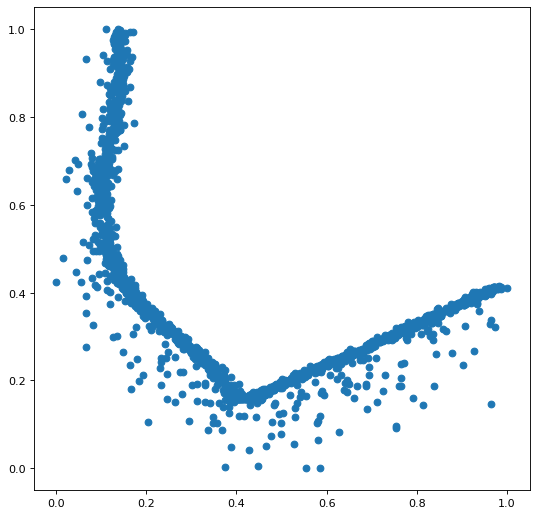

In [163]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.show()

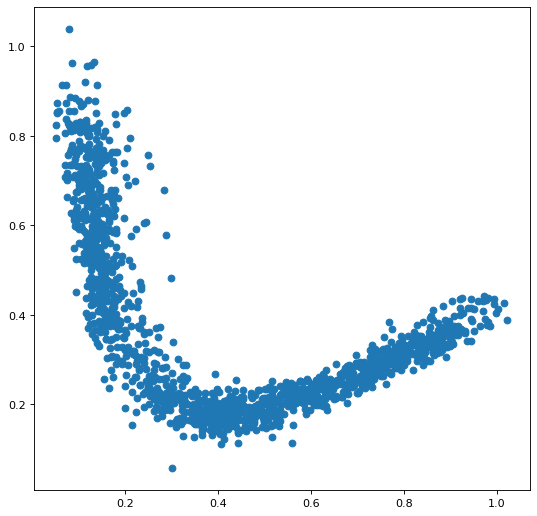

In [165]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1])
plt.show()